In [665]:
#ライブラリのimport
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re 
import time
import shutil
import shap
import locale
import seaborn as sns
import matplotlib as mpl
from dateutil.relativedelta import relativedelta
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec
from datetime import datetime
from datetime import timedelta
from PIL import Image
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error
# フォント設定の変更（日本語対応のため）
mpl.rcParams['font.family'] = 'MS Gothic'

In [3]:
#生データのパス
folder_path_zaikoMB = '生データ/在庫推移MB'
folder_path_LTMB = '生データ/所在管理MB'
folder_path_kumitate = '生データ/組立実績MB'
folder_path_tehaisu = '生データ/手配必要数'
folder_path_tehaiunyo = '生データ/手配運用情報'
folder_path_pitch = '生データ/不等ピッチ係数'
folder_path_kotei = '生データ/使用工程'
#中間成果物のパス
folder_path_interproduct = '中間成果物'
file_path_zaikodata = '中間成果物/在庫推移MBデータ_統合済.csv'
file_path_LTdata = '中間成果物/所在管理MBデータ_統合済.csv'
file_path_kumitate = '中間成果物/組立実績MBデータ_統合済.csv'
file_path_pitch = '中間成果物/不等ピッチデータ_統合済.csv'
file_path_kotei = '中間成果物/使用工程データ_統合済.csv'
file_path_date= '中間成果物/日付ファイル_開始日と終了日記載.txt'
file_path_zaikodata_extract = '中間成果物/在庫推移MBデータ_統合済&特定日時抽出済.csv'
file_path_LTdata_extract = '中間成果物/所在管理MBデータ_統合済&特定日時抽出済.csv'
file_path_kumitate_extract = '中間成果物/組立実績MBデータ_統合済&特定日時抽出済.csv'
file_path_tehaisu_with_tehaiunyo = '中間成果物/手配数データ_手配運用情報統合済'#.csvいらない
file_path_LTdata_extract_with_tehaisu = '中間成果物/所在管理MBデータ_統合済&特定日時抽出済&手配数と手配運用情報統合済.csv'
file_path_weekly_data = '中間成果物/週単位のデータ.csv'
file_path_weekly_data_with_kumitate = '中間成果物/週単位のデータ_組立統合済.csv'
file_path_weekly_data_with_kumitate_and_pitch = '中間成果物/週単位のデータ_組立&不等ピッチ統合済.csv'
file_path_weekly_data_with_kumitate_and_pitch_and_kotei = '中間成果物/週単位のデータ_組立&不等ピッチ＆使用工程統合済.csv'
file_path_weekly_data_with_kumitate_and_pitch_and_kotei_and_others = '中間成果物/週単位のデータ_組立&不等ピッチ＆使用工程統合済＆必要変数追記.csv'
file_path_weekly_data_with_kumitate_and_pitch_and_kotei_and_others_cleaned = '中間成果物/週単位のデータ_組立&不等ピッチ績＆使用工程統合済＆必要変数追記_クリーニング済.csv'
file_path_daily_data='中間成果物/日単位の在庫データ.csv'
file_path_daily_tehaidata='中間成果物/日単位の手配データ.csv'
file_path_merged_daily_data = '中間成果物/日単位のデータ.csv'
file_path_merged_daily_data_with_others = '中間成果物/日単位のデータ_必要変数追加.csv'
file_path_merged_daily_data_with_others_cleaning = '中間成果物/日単位のデータ_必要変数追加_前処理済.csv'
#最終成果物のパス
folder_path_finalproduct = '最終成果物'

In [610]:
start_date = '2023-10-01'
end_date = '2024-03-31'

In [276]:
# フォルダー内の全てのCSVファイルを見つける
csv_files_LTMB = [f for f in os.listdir(folder_path_LTMB) if f.endswith('.csv')]

# フォルダー内にCSVファイルが存在する場合
if len(csv_files_LTMB) != 0:
    
    # 統合結果を保存するための空のDataFrameを作成
    merged_df_LT = pd.DataFrame()
    # CSVファイルをDataFrameに読み込んでリストに保存
    for file in csv_files_LTMB:
        file_path = os.path.join(folder_path_LTMB, file)
        df_LT = pd.read_csv(file_path, encoding='Shift_JIS',dtype=str)
        merged_df_LT = pd.concat([merged_df_LT, df_LT], ignore_index=True)
        
    #重複があれば削除
    merged_df_LT_unique =  merged_df_LT.drop_duplicates(subset=['かんばんシリアル', '伝票番号','品番','順立装置入庫日時'])

    # 不要な特定の列を削除
    merged_df_LT_unique = merged_df_LT_unique.drop("伝票番号", axis=1)
    merged_df_LT_unique = merged_df_LT_unique.drop("拠点所番地", axis=1)
    merged_df_LT_unique = merged_df_LT_unique.drop("組立投入日時", axis=1)
    merged_df_LT_unique = merged_df_LT_unique.drop("発注取消日時", axis=1)
    merged_df_LT_unique = merged_df_LT_unique.drop("発注〜組立LT", axis=1)
    merged_df_LT_unique = merged_df_LT_unique.drop("長期滞留フラグ", axis=1)
    
    #成功メッセージ
    print("\033[34m" + "実行は成功しました！\n次のステップを実行してください!" + "\033[0m")
    print(f"{len(csv_files_LTMB)}つのCSVファイルが見つかりました！\n以下に統合したデータの外観を示します(重複したデータは削除済みです)")
    print(len(merged_df_LT_unique))

    # 統合したデータを新しいCSVファイルに保存
    with open(file_path_LTdata, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
        merged_df_LT_unique.to_csv(f)

    #作成したDataFrameの内容を確認
    display(merged_df_LT_unique)

# フォルダー内にCSVファイルが存在しない場合    
else:
    #失敗メッセージ
    print("\033[31m" + "実行は失敗しました！" + "\033[31m")
    print("CSVファイルが見つかりません！CSVファイルを格納してください")

実行は成功しました！
次のステップを実行してください!
11つのCSVファイルが見つかりました！
以下に統合したデータの外観を示します(重複したデータは削除済みです)
592351


,かんばんシリアル,品番,品名,収容数,仕入先名,仕入先工場名,ステータス,納入日,納入便,発注日時,...,検収日時,順立装置入庫日時,順立装置出庫日時,回収日時,発注〜印刷LT,発注〜検収LT,発注〜順立装置入庫LT,発注〜順立装置出庫LT,発注〜回収LT,更新日時
0,1Z23H00040276,9036324A004,ﾍﾞｱﾘﾝｸﾞﾗｼﾞｱﾙﾎﾞｰﾙ,30,日本精工（株）,三河分室,回収済,2023/08/23,01,2023/08/22 03:45:04,...,2023/08/23 09:18:23,2023/08/23 16:08:59,2023/08/24 10:30:34,2023/08/24 12:18:03,0.08,1.23,1.52,2.28,2.36,2023/08/30 11:13:00
1,1Z23H00040275,9036324A003,ﾍﾞｱﾘﾝｸﾞﾗｼﾞｱﾙﾎﾞｰﾙ,22,日本精工（株）,三河分室,回収済,2023/08/23,01,2023/08/22 03:45:04,...,2023/08/23 09:18:23,2023/08/23 16:10:24,2023/08/24 11:08:10,2023/08/24 16:13:14,0.08,1.23,1.52,2.31,2.52,2023/08/30 11:13:00
2,1Z23H00040274,9030111A014,ﾘﾝｸﾞO,1000,ＮＯＫ（株）,< NULL >,回収済,2023/08/23,02,2023/08/22 01:33:45,...,2023/08/23 20:38:39,2023/08/24 03:12:24,2023/08/25 15:00:33,2023/08/26 05:37:37,0.31,1.8,2.07,3.56,4.17,2023/08/30 11:13:00
3,1Z23H00040272,35505ECB010,ﾚﾊﾞｰS/Aﾊﾟｰｷﾝｸﾞﾛｯｸ,24,中庸スプリング（株）,< NULL >,回収済,2023/08/23,01,2023/08/22 01:53:50,...,2023/08/23 07:21:29,2023/08/23 10:18:36,2023/08/25 05:06:24,2023/08/25 07:11:33,0.32,1.23,1.35,3.13,3.22,2023/08/30 11:13:00
4,1Z23H00040267,G1144ECB010,"ﾀｰﾐﾅﾙ,ﾓｰﾀｰｹｰﾌﾞﾙ",6,住友電気工業（株）,< NULL >,回収済,2023/08/24,01,2023/08/22 04:37:54,...,2023/08/24 13:14:44,2023/08/25 00:49:55,2023/08/26 01:28:27,2023/08/26 04:34:03,1.07,2.36,2.84,3.87,4,2023/08/30 11:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592386,1Z22A00022456,9056455A026,< NULL >,< NULL >,< NULL >,< NULL >,順立装置出庫済,< NULL >,< NULL >,< NULL >,...,< NULL >,< NULL >,2023/02/10 13:04:26,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,2023/08/30 11:13:00
592387,1Z22A00022418,9056451A083,< NULL >,< NULL >,< NULL >,< NULL >,順立装置出庫済,< NULL >,< NULL >,< NULL >,...,< NULL >,2023/03/25 01:50:36,2023/03/28 12:06:08,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,2023/08/30 11:13:00
592388,1Z22A00022398,9056450A007,< NULL >,< NULL >,< NULL >,< NULL >,順立装置内,< NULL >,< NULL >,< NULL >,...,< NULL >,2023/03/29 19:19:10,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,2023/08/30 11:13:00
592389,23B00039903,G9201ECE010,< NULL >,< NULL >,< NULL >,< NULL >,順立装置出庫済,< NULL >,< NULL >,< NULL >,...,< NULL >,< NULL >,2023/02/23 23:18:50,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,2023/08/30 11:13:00


In [611]:
#中間成果物をダウンロード
merged_df_LT_unique = pd.read_csv(file_path_LTdata,encoding='shift_jis')

# datetime型に変換する
#merged_df_LT_unique['検収日時'] = pd.to_datetime(merged_df_LT_unique['検収日時'], errors='coerce')
merged_df_LT_unique['発注日時'] = pd.to_datetime(merged_df_LT_unique['発注日時'], errors='coerce') 

# 入力された日付をdatetime型に変換
start_date = pd.to_datetime(start_date).date()
end_date = pd.to_datetime(end_date).date()

# 特定の日付範囲のDataFrameを取り出す
merged_df_LT2 = merged_df_LT_unique[(merged_df_LT_unique["発注日時"].dt.date >= start_date) & (merged_df_LT_unique["発注日時"].dt.date <= end_date)]

# 日付範囲内のデータが存在するかチェック
if not merged_df_LT2.empty:
    
    #成功メッセージ
    print("\033[34m" + "実行は成功しました！\n次のステップを実行してください!" + "\033[0m")
    print("入力した日付範囲（発注日時）で検収されたかんばんデータを表示します")
    
    # 不要な「Unnamed」列を削除                
    merged_df_LT2 = merged_df_LT2.loc[:, ~merged_df_LT2.columns.str.contains('^Unnamed')]
    
    #インデックスを振り直す
    merged_df_LT2.reset_index(drop=True, inplace=True)

    # 統合したデータを新しいCSVファイルに保存
    with open(file_path_LTdata_extract, mode='w',newline='', encoding='shift_jis',errors='ignore') as f:
        merged_df_LT2.to_csv(f)
    
    # 最も古い時間を取得
    oldest_time = merged_df_LT2['発注日時'].min()

    # 最も新しい時間を取得
    newest_time = merged_df_LT2['発注日時'].max()

    print("最も古い時間:", oldest_time)
    print("最も新しい時間:", newest_time)

    #作成したDataFrameの内容を確認
    display(merged_df_LT2)

# 条件を満たす行が存在しない場合の処理
else:
    #失敗メッセージ
    print("\033[31m" + "実行は失敗しました！" + "\033[31m")
    print("入力した日付範囲（発注日時）が存在しません！入力した日付もしくはデータを確認してください！")

実行は成功しました！
次のステップを実行してください!
入力した日付範囲（発注日時）で検収されたかんばんデータを表示します
最も古い時間: 2023-10-02 08:50:22
最も新しい時間: 2024-01-25 11:45:49


,かんばんシリアル,品番,品名,収容数,仕入先名,仕入先工場名,ステータス,納入日,納入便,発注日時,...,検収日時,順立装置入庫日時,順立装置出庫日時,回収日時,発注〜印刷LT,発注〜検収LT,発注〜順立装置入庫LT,発注〜順立装置出庫LT,発注〜回収LT,更新日時
0,1Z23K00099322,9031150A015,ｼｰﾙﾀｲﾌﾟTｵｲﾙ,84,ＮＯＫ（株）,NaN,回収済,2023/10/31,02,2023-10-28 01:20:52,...,2023/10/31 20:44:12,2023/11/01 04:05:56,2023/11/01 06:55:27,2023/11/01 22:17:40,2.32,3.81,4.11,4.23,4.87,2023/11/01 22:17:40
1,1Z23K00099319,9031150A014,ｼｰﾙﾀｲﾌﾟTｵｲﾙ,84,ＮＯＫ（株）,NaN,回収済,2023/10/31,02,2023-10-28 01:20:52,...,2023/10/31 20:44:12,2023/11/01 04:08:16,2023/11/01 09:39:46,2023/11/01 22:17:40,2.32,3.81,4.12,4.35,4.87,2023/11/01 22:17:40
2,1Z23K00098163,9031150A015,ｼｰﾙﾀｲﾌﾟTｵｲﾙ,84,ＮＯＫ（株）,NaN,回収済,2023/10/31,02,2023-10-28 01:20:52,...,2023/10/31 20:44:12,2023/11/01 04:05:19,2023/11/01 09:40:04,2023/11/01 22:17:40,2.32,3.81,4.11,4.35,4.87,2023/11/01 22:17:40
3,1Z23K00094456,9030119A010,ﾘﾝｸﾞO,1000,ＮＯＫ（株）,NaN,回収済,2023/10/30,02,2023-10-27 01:13:27,...,2023/10/30 20:52:12,2023/10/31 04:08:24,2023/10/31 14:54:38,2023/11/01 22:17:40,0.32,3.82,4.12,4.57,5.88,2023/11/01 22:17:40
4,1Z23K00069411,9030119A011,ﾘﾝｸﾞO,200,ＮＯＫ（株）,NaN,回収済,2023/10/27,01,2023-10-25 11:48:02,...,2023/10/27 10:12:03,2023/10/27 14:14:24,2023/11/01 15:39:39,2023/11/01 22:17:40,0.14,1.93,2.1,7.16,7.44,2023/11/01 22:17:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161381,1Z23M00004552,35141ECE010,ｹ-ｽT/A,20,（株）アイシン福井,本社工場,回収済,2023/12/04,19,2023-12-02 06:16:11,...,2023/12/05 03:45:30,2023/12/05 03:09:23,2023/12/06 10:37:39,2023/12/06 12:13:39,2.19,2.9,2.87,4.18,4.25,2023/12/06 12:13:39
161382,1Z23M00004266,35141ECE010,ｹ-ｽT/A,20,（株）アイシン福井,本社工場,回収済,2023/12/04,17,2023-12-02 04:31:55,...,2023/12/05 03:45:30,2023/12/05 00:38:09,2023/12/06 09:24:09,2023/12/06 12:13:39,2.19,2.97,2.84,4.2,4.32,2023/12/06 12:13:39
161383,1Z23M00003430,9034108A010,ﾌﾟﾗｸﾞｳｲｽﾞﾍﾂﾄﾞｽﾄﾚ-ﾄｽｸﾘﾕ-,1000,（株）杉浦製作所,NaN,回収済,2023/12/04,02,2023-12-02 01:54:02,...,2023/12/04 18:14:25,2023/12/04 22:07:13,2023/12/06 01:49:12,2023/12/06 12:13:39,0.13,2.68,2.84,4,4.43,2023/12/06 12:13:39
161384,1Z23M00003237,39171ECE010,"ｶﾊﾞｰ,ﾓｰﾀﾊｳｼﾞﾝｸﾞ",20,（株）アイシン福井,本社工場,回収済,2023/12/04,09,2023-12-01 18:08:36,...,2023/12/04 23:29:33,2023/12/05 14:00:34,2023/12/06 08:57:49,2023/12/06 12:13:39,0.28,3.22,3.83,4.62,4.75,2023/12/06 12:13:39


In [635]:
import pandas as pd

def calculate_arrival_times(df, time_columns):
    # タイプが着時刻の行のみを抽出
    arrival_df = df[df['タイプ'] == '着時刻']

    # 1便以降の日付データを時間だけに変換
    for col in time_columns:
        arrival_df[col] = pd.to_datetime(arrival_df[col].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')[0], format='%H:%M:%S', errors='coerce').dt.time

    # 早着、定刻、遅着の時間帯を計算
    arrival_df_with_times = arrival_df.copy()
    for col in time_columns:
        arrival_time = pd.to_datetime(arrival_df[col].astype(str), format='%H:%M:%S', errors='coerce')
        arrival_df_with_times[col + '_早着'] = (arrival_time - pd.Timedelta(hours=2)).dt.time
        #arrival_df_with_times[col + '_早着_終了'] = arrival_time.dt.time
        arrival_df_with_times[col + '_定刻'] = arrival_time.dt.time
        #arrival_df_with_times[col + '_定刻_終了'] = (arrival_time + pd.Timedelta(hours=1)).dt.time
        arrival_df_with_times[col + '_遅着'] = (arrival_time + pd.Timedelta(hours=2)).dt.time
        #arrival_df_with_times[col + '_遅着_終了'] = (arrival_time + pd.Timedelta(hours=2)).dt.time

    # 必要な列のみを抽出して返す
    result_columns = ['仕入先名', '発送場所名', '受入'] + [col for col in arrival_df_with_times.columns if '早着' in col or '定刻' in col or '遅着' in col]
    return arrival_df_with_times[result_columns]

# ファイルパス
file_path = '生データ/便ダイヤ/仕入先便ダイヤ.xlsx'

# openpyxlエンジンを使用してExcelファイルを読み込む
df = pd.read_excel(file_path, engine='openpyxl')

# 5行目を列名として設定し、6行目以降のデータを抽出
df.columns = df.iloc[5]
df = df[6:]

# 列名をリセット
df.columns = df.columns.str.strip()
df.reset_index(drop=True, inplace=True)

# 抽出したい列名を指定
columns_to_extract = ['仕入先名', '発送場所名', '受入', 'タイプ', '1便', '2便', '3便', '4便', '5便', '6便', '7便', '8便', '9便', '10便', '11便', '12便']
#columns_to_extract = ['仕入先名', '発送場所名', '受入', 'タイプ','4便', '5便', '6便']

# 指定した列のみを抽出
extracted_df = df[columns_to_extract]

# 関数を使用して早着、定刻、遅着の時間帯を計算
arrival_times_df = calculate_arrival_times(extracted_df, columns_to_extract[4:])

# NaNの値を'< NULL >'に置換
# 所在管理と結合するため
arrival_times_df = arrival_times_df.fillna('< NULL >')

# 最終結果を表示
arrival_times_df.head(10)

/anaconda/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


5,仕入先名,発送場所名,受入,1便_早着,1便_定刻,1便_遅着,2便_早着,2便_定刻,2便_遅着,3便_早着,...,9便_遅着,10便_早着,10便_定刻,10便_遅着,11便_早着,11便_定刻,11便_遅着,12便_早着,12便_定刻,12便_遅着
0,アイシン精機（株）,半田工場,1Y,08:30:00,10:30:00,12:30:00,12:40:00,14:40:00,16:40:00,19:00:00,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >
2,（株）青山製作所,< NULL >,1Y,05:00:00,07:00:00,09:00:00,09:20:00,11:20:00,13:20:00,12:55:00,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >
4,（株）浅賀井製作所,安城工場,1Y,07:50:00,09:50:00,11:50:00,13:10:00,15:10:00,17:10:00,19:30:00,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >
6,（株）旭工業所,本社工場,1Y,14:40:00,16:40:00,18:40:00,< NULL >,< NULL >,< NULL >,< NULL >,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >
8,愛産樹脂工業（株）,本社工場,1Y,13:00:00,15:00:00,17:00:00,< NULL >,< NULL >,< NULL >,< NULL >,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >
10,石黒ゴム工業（株）,< NULL >,1Y,06:45:00,08:45:00,10:45:00,12:00:00,14:00:00,16:00:00,< NULL >,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >
12,伊藤金属工業（株）,< NULL >,1Y,11:00:00,13:00:00,15:00:00,< NULL >,< NULL >,< NULL >,< NULL >,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >
14,（株）オーハシテクニカ,< NULL >,1Y,13:20:00,15:20:00,17:20:00,< NULL >,< NULL >,< NULL >,< NULL >,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >
16,大橋鉄工（株）,< NULL >,1Y,14:20:00,16:20:00,18:20:00,< NULL >,< NULL >,< NULL >,< NULL >,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >
18,岡谷鋼機（株）,刈谷支店,1Y,19:50:00,21:50:00,23:50:00,< NULL >,< NULL >,< NULL >,< NULL >,...,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >,< NULL >


In [279]:
def add_previous_hours_data(df, X):
    """
    データフレームに1時間前からX時間前までの「便合計」のデータ列を追加する関数。

    Args:
    df (DataFrame): 入力データフレーム。
    X (int): 追加する時間の範囲（1時間前からX時間前まで）。

    Returns:
    DataFrame: 更新されたデータフレーム。
    """
    for i in range(1, X + 1):
        df[f'{i}時間前荷役時間'] = df['荷役時間'].shift(i)
    return df

#ファイル読み込み
file_path_teikibin = '定期便.csv'
teikibin_data = pd.read_csv(file_path_teikibin, encoding='shift_jis')

# 日時の列を datetime 型に変換
teikibin_data['JISEKI_DT'] = pd.to_datetime(teikibin_data['JISEKI_DT'])
teikibin_data['JISEKI_DT2'] = pd.to_datetime(teikibin_data['JISEKI_DT2'])
#1時間単位に変換
teikibin_data['定期便到着時刻（1H）'] = pd.to_datetime(teikibin_data['JISEKI_DT']).dt.floor('H')
teikibin_data['定期便出発時刻（1H）'] = pd.to_datetime(teikibin_data['JISEKI_DT2']).dt.floor('H')
# 日時の差を計算
teikibin_data["荷役時間"] = teikibin_data['JISEKI_DT2'] - teikibin_data['JISEKI_DT']

# 各WORK_IDと定期便到着時刻（1H）の組み合わせに対して荷役時間の合計を計算
grouped = teikibin_data.groupby(['WORK_ID', '定期便到着時刻（1H）'])['荷役時間'].sum().reset_index()

# 1時間毎のデータフレームに各WORK_IDごとの「定期便到着時刻（1H）」列を追加する
date_range = pd.date_range(start = start_date, end = end_date, freq='H')

# YYYYMMDDHに全ての時間帯をマッピング
all_hours_df = pd.DataFrame(date_range, columns=['YYYYMMDDH']).set_index('YYYYMMDDH')

# 結果を保存するための空のDataFrameを準備
result_df = all_hours_df.copy()

# 元のデータセットからユニークなWORK_IDを抽出する
unique_work_ids = teikibin_data['WORK_ID'].unique()

for work_id in unique_work_ids:
    # 特定のWORK_IDに対する荷役時間を含む時間帯のデータフレームを抽出
    work_times = grouped[grouped['WORK_ID'] == work_id]
    work_times = work_times.set_index('定期便到着時刻（1H）')
    # 荷役時間を1時間ごとのデータフレームにマージ
    result_df[f'荷役時間_便_{work_id}'] = work_times['荷役時間']

result_df_reset = result_df.reset_index()

# 荷役時間を分単位に変換し、float型で保存するために、Timedeltaを分に変換する処理を行います。
for col in result_df_reset.columns:
    if "便" in col:
        # Timedeltaを分に変換
        result_df_reset[col] = result_df_reset[col].dt.total_seconds() / 60

pattern_columns = result_df_reset.filter(regex='荷役時間_便_[0\d\W]+').columns
print(pattern_columns)

result_df_reset['荷役時間']=result_df_reset[pattern_columns].sum(axis=1)
result_df_reset.fillna(0, inplace=True)  # 一括でNaNを0に変換

# 関数を使用してデータフレームを更新
X = 8  # 1時間前から5時間前までのデータ列を追加
updated_df = add_previous_hours_data(result_df_reset, X)

# 更新されたデータフレームの最初の数行を表示して内容を確認
updated_df.head()

# 結果の一部を表示して確認
result_df_reset.head(100)
# 日付範囲に基づいてデータをフィルタリング
start_date_temp = pd.Timestamp('2023-10-05')
end_date_temp = pd.Timestamp('2023-10-06')
f = result_df_reset[(result_df_reset['YYYYMMDDH'] >= start_date_temp) & (result_df_reset['YYYYMMDDH'] <= end_date_temp)]
f.head(20)

Index(['荷役時間_便_01', '荷役時間_便_02', '荷役時間_便_03', '荷役時間_便_04', '荷役時間_便_05',
       '荷役時間_便_06', '荷役時間_便_0K'],
      dtype='object')


,YYYYMMDDH,荷役時間_便_01,荷役時間_便_02,荷役時間_便_03,荷役時間_便_04,荷役時間_便_05,荷役時間_便_06,荷役時間_便_0K,荷役時間,1時間前荷役時間,2時間前荷役時間,3時間前荷役時間,4時間前荷役時間,5時間前荷役時間,6時間前荷役時間,7時間前荷役時間,8時間前荷役時間
96,2023-10-05 00:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450,0.000000
97,2023-10-05 01:00:00,0.0000,0.000000,0.00000,0.0,41.56105,0.000000,0.0,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000,47.717450
98,2023-10-05 02:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000,0.000000
99,2023-10-05 03:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000,0.000000
100,2023-10-05 04:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167,0.000000
101,2023-10-05 05:00:00,0.0000,0.000000,0.00000,0.0,0.00000,32.464383,0.0,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000,18.277167
102,2023-10-05 06:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000,0.000000
103,2023-10-05 07:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000,0.000000
104,2023-10-05 08:00:00,0.0000,0.000000,0.00000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050,0.000000
105,2023-10-05 09:00:00,31.4504,0.000000,0.00000,0.0,0.00000,0.000000,0.0,31.450400,0.000000,0.000000,0.000000,32.464383,0.000000,0.000000,0.000000,41.561050


In [9]:
def set_A_B_columns(row, df):

    if row['TYOKU_KBN(1)'] == 1:
        jikankwari_map = {
            1: ('8:30', 0.5, None, '8:00'),
            2: ('9:30', 0.5, 1, '9:00'),
            3: ('10:30', 0.5, 2, '10:00'),
            4: ('11:30', 0.5, 3, '11:00'),
            5: ('12:30', 0.5, 4, '12:00'),
            6: ('13:25', 0.5, 5, '13:00'),
            7: ('14:20', 2/3, 6, '14:00', 1/3),
            8: ('15:20', 2/3, 7, '15:00', 1/3),
            9: ('16:20', 2/3, 8, '16:00', 1/3),
            10: ('17:20', 2/3, 9, '17:00', 1/3),
            11: ('18:30', 0.5, 10, '18:00', 0.5),
            12: ('19:30', 0.5, 11, '19:00', 0.5),
            13: ('20:30', 0.5, 12, '20:00', 0.5)
        }
        if row['JIKANWARI_KBN'] in jikankwari_map:
            mapping = jikankwari_map[row['JIKANWARI_KBN']]
            row['時間割区分_開始時刻'] = mapping[0]
            row['調整日時'] = mapping[3]
            row['LINE_DATE_修正済'] = row['LINE_DATE']
            weight = mapping[1]
            previous_jikankwari_kbn = mapping[2]
            if previous_jikankwari_kbn is not None:
                previous_product_cnt = df[(df['LINE_DATE'] == row['LINE_DATE']) & (df['JIKANWARI_KBN'] == previous_jikankwari_kbn)]['PRODUCT_CNT']
                previous_plan_product_cnt = df[(df['LINE_DATE'] == row['LINE_DATE']) & (df['JIKANWARI_KBN'] == previous_jikankwari_kbn)]['PLAN_PRODUCT_CNT']
                #if row['KUMI_CD'] == 'NH11':
                        #print(row['時間割区分_開始時刻'],len(previous_product_cnt))
                if not previous_product_cnt.empty:
                    if len(mapping) == 4:
                        row['生産台数_加重平均済'] = (row['PRODUCT_CNT'] * weight + previous_product_cnt.iloc[0] * weight)
                        row['計画生産台数_加重平均済'] = (row['PLAN_PRODUCT_CNT'] * weight + previous_plan_product_cnt.iloc[0] * weight)
                        #if row['KUMI_CD'] == 'NH12':
                            #print(row['時間割区分_開始時刻'],previous_product_cnt.iloc[0],row['PRODUCT_CNT'],len(previous_product_cnt))
                    else:
                        previous_weight = mapping[4]
                        row['生産台数_加重平均済'] = (row['PRODUCT_CNT'] * weight + previous_product_cnt.iloc[0] * previous_weight)
                        row['計画生産台数_加重平均済'] = (row['PLAN_PRODUCT_CNT'] * weight + previous_plan_product_cnt.iloc[0] * previous_weight)
                else:
                    row['生産台数_加重平均済'] = row['PRODUCT_CNT'] * weight
                    row['計画生産台数_加重平均済'] = row['PLAN_PRODUCT_CNT'] * weight
            else:
                row['生産台数_加重平均済'] = row['PRODUCT_CNT'] * weight
                row['計画生産台数_加重平均済'] = row['PLAN_PRODUCT_CNT'] * weight
                
    elif row['TYOKU_KBN(1)'] == 2:
        jikankwari_map = {
            1: ('21:00', '21:00', None, 0),
            2: ('22:00', '22:00', None, 0),
            3: ('23:00', '23:00', None, 0),
            4: ('0:00', '0:00', None, 1),
            5: ('1:00', '1:00', None, 1),
            6: ('2:00', '2:00', None, 1),
            7: ('3:00', '3:00', None, 1),
            8: ('4:00', '4:00', None, 1),
            9: ('5:00', '5:00', None, 1),
            10: ('6:00', '６:00', None, 1),
            11: ('7:00', '7:00', None, 1),
            #12: ('8:00', '8:00', None, 1)
        }
        if row['JIKANWARI_KBN'] in jikankwari_map:
            mapping = jikankwari_map[row['JIKANWARI_KBN']]
            row['時間割区分_開始時刻'] = mapping[0]
            row['計画生産台数_加重平均済'] = row['PLAN_PRODUCT_CNT']
            row['生産台数_加重平均済'] = row['PRODUCT_CNT']
            row['調整日時'] = mapping[1]
            row['LINE_DATE_修正済'] = row['LINE_DATE'] + pd.Timedelta(days=mapping[3])
            
    return row

#MBから吸い出したもの
file_path_kumitatedaisu = '組立生産台数.csv'
kumitate_data = pd.read_csv(file_path_kumitatedaisu, encoding='shift_jis')
# 'LINE_DATE'列をdatetime型に変換
# 'LINE_DATE'列は常に0:00を表す
kumitate_data['LINE_DATE'] = pd.to_datetime(kumitate_data['LINE_DATE'])

print(len(kumitate_data.columns))

# 'PLAN_PRODUCT_CNT' にNaNがある行を削除
# ★関数通す前にこれしないと、NH11とNH12の結果が関数でヒットして、NH12の昼勤計算がうまくいかなくなる
kumitate_data = kumitate_data.dropna(subset=['PRODUCT_CNT'])

# すべての列をfloat型に変換
#kumitate_data[['PLAN_PRODUCT_CNT','PRODUCT_CNT','TYOKU_KBN(1)']] = kumitate_data[['PLAN_PRODUCT_CNT','PRODUCT_CNT','TYOKU_KBN(1)']].astype(float)

# 関数を適用
kumitate_data = kumitate_data.apply(lambda row: set_A_B_columns(row, kumitate_data), axis=1)

kumitate_data['計画達成率_加重平均済'] = kumitate_data['生産台数_加重平均済']/kumitate_data['計画生産台数_加重平均済']

# 'PLAN_PRODUCT_CNT' にNaNがある行を削除
kumitate_data = kumitate_data.dropna(subset=['PRODUCT_CNT'])

# '計画達成率_加重平均済' 列の NaN を 0 に置き換える
#kumitate_data['計画達成率_加重平均済'] = kumitate_data['計画達成率_加重平均済'].fillna(0)
#kumitate_data['生産台数_加重平均済'] = kumitate_data['生産台数_加重平均済'].fillna(0)
#kumitate_data['計画生産台数_加重平均済'] = kumitate_data['計画生産台数_加重平均済'].fillna(0)

# LINE_DATE_修正済と調整日時を結合して新しい列Xを作成
kumitate_data['LINE_DATE_修正済'] = pd.to_datetime(kumitate_data['LINE_DATE_修正済'])
# 調整日時 も datetime 型に変換
kumitate_data['調整日時'] = pd.to_datetime(kumitate_data['調整日時'], format='%H:%M').dt.time
# NaTを処理するためにfillnaを使用して、調整日時の欠損値をデフォルトの時間に置き換え
kumitate_data['調整日時'] = kumitate_data['調整日時'].fillna(pd.to_datetime('00:00').time())
kumitate_data['日時'] = kumitate_data.apply(lambda row: pd.datetime.combine(row['LINE_DATE_修正済'], row['調整日時']), axis=1)

# 'PLAN_PRODUCT_CNT' にNaNがある行を削除
kumitate_data = kumitate_data.dropna(subset=['時間割区分_開始時刻'])

# 日時順に並び替え
kumitate_data = kumitate_data.sort_values(by='日時')

#結果を表示
# 日付をindexに設定表示のため一時的に日付をindexに設定
kumitate_data = kumitate_data.set_index('LINE_DATE')
# データフレームの各列の型を確認する
print(kumitate_data.dtypes)
# 特定の日付範囲を指定
temp_start_date = '2023-12-06'
temp_end_date = '2023-12-13'
# 日付範囲でフィルタリング
specific_date_range = kumitate_data[(kumitate_data.index >= temp_start_date) & (kumitate_data.index <= temp_end_date)]
# フィルタリングされたデータを表示
specific_date_range = specific_date_range.reset_index()
kumitate_data = kumitate_data.reset_index()
specific_date_range.head(55)

6
JIKANWARI_KBN                int64
KUMI_CD                     object
LINE_DATE_修正済       datetime64[ns]
PLAN_PRODUCT_CNT           float64
PRODUCT_CNT                float64
TYOKU_KBN(1)                 int64
時間割区分_開始時刻                  object
生産台数_加重平均済                 float64
計画生産台数_加重平均済               float64
調整日時                        object
計画達成率_加重平均済                float64
日時                          object
dtype: object


,LINE_DATE,JIKANWARI_KBN,KUMI_CD,LINE_DATE_修正済,PLAN_PRODUCT_CNT,PRODUCT_CNT,TYOKU_KBN(1),時間割区分_開始時刻,生産台数_加重平均済,計画生産台数_加重平均済,調整日時,計画達成率_加重平均済,日時
0,2023-12-06,1,NH12,2023-12-06,100.0,98.0,1,8:30,49.000000,50.000000,08:00:00,0.980000,2023-12-06 08:00:00
1,2023-12-06,2,NH12,2023-12-06,108.0,108.0,1,9:30,54.000000,54.000000,09:00:00,1.000000,2023-12-06 09:00:00
2,2023-12-06,3,NH12,2023-12-06,88.0,88.0,1,10:30,94.500000,94.000000,10:00:00,1.005319,2023-12-06 10:00:00
3,2023-12-06,4,NH12,2023-12-06,108.0,108.0,1,11:30,107.500000,108.000000,11:00:00,0.995370,2023-12-06 11:00:00
4,2023-12-06,5,NH12,2023-12-06,0.0,0.0,1,12:30,45.000000,44.000000,12:00:00,1.022727,2023-12-06 12:00:00
5,2023-12-06,6,NH12,2023-12-06,0.0,0.0,1,13:25,53.500000,54.000000,13:00:00,0.990741,2023-12-06 13:00:00
6,2023-12-06,7,NH12,2023-12-06,80.0,77.0,1,14:20,51.666667,53.333333,14:00:00,0.968750,2023-12-06 14:00:00
7,2023-12-06,8,NH12,2023-12-06,88.0,88.0,1,15:20,92.333333,92.000000,15:00:00,1.003623,2023-12-06 15:00:00
8,2023-12-06,9,NH12,2023-12-06,108.0,108.0,1,16:20,107.333333,107.333333,16:00:00,1.000000,2023-12-06 16:00:00
9,2023-12-06,10,NH12,2023-12-06,89.0,98.0,1,17:20,95.666667,89.333333,17:00:00,1.070896,2023-12-06 17:00:00


In [161]:
folder_path_tehaisu = '生データ/手配必要数'

# フォルダー内の全てのCSVファイルを見つける
csv_files_tehaisu = [f for f in os.listdir(folder_path_tehaisu) if f.endswith('.csv')]
year_tehaisu = [file[2:4] for file in os.listdir(folder_path_tehaisu) if file.endswith(".csv")]
month_tehaisu = [str(int(file[4:6])) for file in os.listdir(folder_path_tehaisu) if file.endswith(".csv")]

# フォルダー内にCSVファイルが存在する場合
if len(csv_files_tehaisu) != 0:
    
    #成功メッセージ
    print("\033[34m" + "実行は成功しました！\n次のステップを実行してください!" + "\033[0m")
    
    print(f"{len(csv_files_tehaisu)}つのファイルが見つかりました！")
    for i in range(len(year_tehaisu)):
        print(f"●{year_tehaisu[i]}年の{month_tehaisu[i]}月のデータが見つかりました！") 
        
# フォルダー内にCSVファイルが存在しない場合    
else:
    #失敗メッセージ
    print("\033[31m" + "実行は失敗しました！" + "\033[31m")
    print("CSVファイルが見つかりません！CSVファイルを格納してください")
    
#日付範囲の計算
year_diff = end_date.year - start_date.year
month_diff = end_date.month - start_date.month
total_months =  year_diff * 12 + month_diff + 1
print(f"あなたが入力した日付範囲は{total_months}ヶ月分です")

#年単位、月単位で分割するためのリスト準備
input_years = []
input_months = []

#実行動作の確認
flag_count = 0

#データの確認
start_date_temp = start_date
for i in range(total_months):
    
    input_year = str(start_date_temp.year)[2:]
    input_month = start_date_temp.month
    print(f"●{i+1}ヶ月目：{input_year}年{input_month}月のデータが存在するか確認します")
    start_date_temp = start_date_temp + relativedelta(months=1)
    
    input_years.append(input_year)
    input_months.append(input_month)
    
    flag = 0
    for j in range(len(csv_files_tehaisu)):
        if (int(input_year) == int(year_tehaisu[j])) and (int(input_month) == int(month_tehaisu[j])):
            flag = 1
    if flag == 1:
        print("\033[34m" + "実行は成功しました!" + "\033[0m")
        print("手配必要数あります")
        flag_count = flag_count + 1
    elif flag == 0:
        #失敗メッセージ
        print("\033[31m" + "実行は失敗しました！" + "\033[31m")
        print(f"{input_year}年{input_month}月の手配数ありません")
        
    flag = 0
    for j in range(len(csv_files_tehaiunyo)):
        if (int(input_year) == int(year_tehaiunyo[j])) and (int(input_month) == int(month_tehaiunyo[j])):
            flag = 1
    if flag == 1:
        #成功メッセージ
        print("\033[34m" + "実行は成功しました！" + "\033[0m")
        print("手配運用情報あります")
        flag_count = flag_count + 1
    elif flag == 0:
        #失敗メッセージ
        print("\033[31m" + "実行は失敗しました！" + "\033[31m")
        print(f"{input_year}年{input_month}月の手配運用情報ありません")
        
print("----結果を表示します-----")
    
if flag_count/2 == total_months:
    #成功メッセージ
    print("\033[34m" + "実行は成功しました！\n次のステップを実行してください!" + "\033[0m")
    print("入力した日付範囲の手配数ファイルと手配運用情報ファイルは存在します")
    flag_count = flag_count + 1
else:
    #失敗メッセージ
    print("\033[31m" + "実行は失敗しました！" + "\033[31m")
    print("入力した日付範囲の手配数ファイルor手配運用情報ファイルは存在しません。出力スクリプトを確認してください")

実行は成功しました！
次のステップを実行してください!
3つのファイルが見つかりました！
●23年の10月のデータが見つかりました！
●23年の11月のデータが見つかりました！
●23年の12月のデータが見つかりました！


AttributeError: 'str' object has no attribute 'year'

In [657]:
def calculate_hourly_counts(df, part_number, time_col, start_date, end_date):
    
    """
    指定された品番のイベント時間（1時間）ごとのかんばん数、納入便、平均検収時間を計算する関数
    
    Parameters:
    df (pd.DataFrame): データフレーム
    part_number (str): 対象品番
    time_col (str): イベント時間を表す列名
    start_date (str): 開始日付（YYYY-MM-DD形式）
    end_date (str): 終了日付（YYYY-MM-DD形式）
    
    Returns:
    pd.DataFrame: 1時間ごとのかんばん数と納入便および平均検収時間
    """
    
    # 品番でフィルタリング
    filtered_df = df[df['品番'] == part_number].copy()
    
    # イベント時間を1時間単位に丸める
    filtered_df['イベント時間'] = pd.to_datetime(filtered_df[time_col], errors='coerce').dt.floor('H')
    
    # 指定された期間内のイベント時間ごとのかんばん数を計算
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # 非稼動日の時間を削除する関数
    # 土曜日9時から月曜7時までの時間を除外
    def is_excluded_time(timestamp):
        #土曜日（weekday() == 5）の9時以降であれば、True を返す
        if timestamp.weekday() == 5 and timestamp.hour >= 9:
            return True
        #日曜日（weekday() == 6）であれば、True を返す。
        if timestamp.weekday() == 6:
            return True
        #月曜日（weekday() == 0）の8時未満であれば、True を返す
        if timestamp.weekday() == 0 and timestamp.hour < 8:
            return True
        return False
    
    # 除外された時間をフィルタリング
    date_range = [dt for dt in date_range if not is_excluded_time(dt)]
    filtered_df = filtered_df[filtered_df['イベント時間'].isin(date_range)]
    
    # 非稼動日時間を削除済み
    hourly_counts = filtered_df.groupby('イベント時間').size().reindex(date_range, fill_value=0)
    
    delivery_totals = []
    reception_times = []
    if time_col == '検収日時':
        delivery_col = '納入便'
        # 納入便をint型に変換
        filtered_df[delivery_col] = filtered_df[delivery_col].astype(int)
        # イベント時間ごとの納入便の合計を計算
        delivery_totals = filtered_df.groupby('イベント時間')[delivery_col].sum().reindex(date_range, fill_value=0)
        # 結果データフレームを作成して納入便の合計を追加
        delivery_totals = delivery_totals / hourly_counts # 納入便数の計算
        delivery_totals = delivery_totals.fillna(0)  # NaNを0に置き換え
        delivery_totals = delivery_totals.astype(int) # int型に変換
        # イベント時間ごとの平均検収時間を計算
        reception_times = filtered_df.groupby('イベント時間')[time_col].apply(lambda x: pd.to_datetime(x.dt.time.astype(str)).mean().time()).reindex(date_range)
        reception_times = reception_times.fillna('00:00:00')  # NaNを00:00:00に置き換え
    
    return hourly_counts, delivery_totals, reception_times

def calculate_business_time_base(row, order_datetime, warehouse_datetime):
    
    # 発注日時または順立装置入庫日時がNaTの場合、NaNを返す
    if pd.isna(order_datetime) or pd.isna(warehouse_datetime):
        return np.nan

    # 全体の時間差を計算
    total_time = warehouse_datetime - order_datetime
    current_datetime = order_datetime

    # 発注日時から順立装置入庫日時までの期間を1時間ごとに進める
    while current_datetime < warehouse_datetime:
        # 土曜の9時から月曜の7時までの間の時間を除去
        if current_datetime.weekday() == 5 and current_datetime.hour >= 9:  # 土曜日の9時以降
            next_monday = current_datetime + pd.Timedelta(days=2)
            next_monday = next_monday.replace(hour=7, minute=0, second=0)
            if next_monday < warehouse_datetime:
                total_time -= next_monday - current_datetime
                current_datetime = next_monday
            else:
                total_time -= warehouse_datetime - current_datetime
                break
        else:
            # 1時間進める
            current_datetime += pd.Timedelta(hours=1)
            if current_datetime.weekday() == 5 and current_datetime.hour == 9:
                # 進めた結果が土曜日の9時に到達した場合
                next_monday = current_datetime + pd.Timedelta(days=2)
                next_monday = next_monday.replace(hour=7, minute=0, second=0)
                if next_monday < warehouse_datetime:
                    total_time -= next_monday - current_datetime
                    current_datetime = next_monday
                else:
                    total_time -= warehouse_datetime - current_datetime
                    break

    # 日数として計算し、小数点形式に変換
    return total_time.total_seconds() / (24 * 3600)

# ビジネスタイムの差分を計算する関数
def calculate_business_time_order(row):
    
    order_datetime = row['発注日時']
    warehouse_datetime = row['順立装置入庫日時']

    # 日数として計算し、小数点形式に変換
    return calculate_business_time_base(row, order_datetime, warehouse_datetime)

def calculate_business_time_reception(row):
    
    order_datetime = row['検収日時']
    warehouse_datetime = row['順立装置入庫日時']

    # 日数として計算し、小数点形式に変換
    return calculate_business_time_base(row, order_datetime, warehouse_datetime)

def calculate_median_lt(product_code,df):
    
    """
    指定された品番の発注〜順立装置入庫LTの中央値を計算する関数。

    Parameters:
    product_code (str): 品番

    Returns:
    float: 発注〜順立装置入庫LTの中央値
    """
    
    # 指定された品番のデータをフィルタリング
    filtered_df = df[df['品番'] == product_code]

    # フィルタリングされたデータが空かどうかをチェック
    if filtered_df.empty:
        return None

    # '発注〜順立装置入庫LT'
    filtered_df['発注〜順立装置入庫LT（非稼動日削除）'] = filtered_df.apply(calculate_business_time_order, axis=1)
    filtered_df['検収〜順立装置入庫LT（非稼動日削除）'] = filtered_df.apply(calculate_business_time_reception, axis=1)

    # フィルタリングされたデータが空かどうかを再チェック
    if filtered_df.empty:
        return None

    # '発注〜順立装置入庫LT'の中央値を計算
    median_value_order = filtered_df['発注〜順立装置入庫LT（非稼動日削除）'].median()
    median_value_reception = filtered_df['検収〜順立装置入庫LT（非稼動日削除）'].median()
    
    #確認用
    #print(filtered_df[['発注日時','順立装置入庫日時','発注〜順立装置入庫LT','発注〜順立装置入庫LT（非稼動日削除）']].head(50))

    return median_value_order, median_value_reception

def find_best_lag_range(hourly_data, hourly_target, min_lag, max_lag, label_name):
    
    """
    指定された範囲内でイベントの最適な遅れ範囲を見つける関数。
    
    Parameters:
    hourly_data (pd.Series): 1時間ごとのイベント数
    hourly_target (pd.Series): 1時間ごとのターゲットイベント数
    min_lag (int): 最小遅れ時間
    max_lag (int): 最大遅れ時間
    label_name (str): ローリング平均のラベル名
    
    Returns:
    tuple: (最適な相関係数, 最適な遅れ範囲の開始, 最適な遅れ範囲の終了)
    """
    
    best_corr = -1
    best_range_start = None
    best_range_end = None
    
    # 最適な遅れ範囲を探索
    for range_start in range(min_lag, max_lag - 1):
        for range_end in range(range_start + 2, max_lag + 1):
            lag_features = pd.DataFrame(index=hourly_data.index)
            
            # 遅れ範囲に基づいてイベント数のローリング平均を計算
            lag_features[f'{label_name}_lag_{range_start}-{range_end}'] = hourly_data.shift(range_start).rolling(window=range_end - range_start + 1).mean()
            lag_features['target'] = hourly_target
            
            # 欠損値を除去
            lag_features = lag_features.dropna()
            
            # 相関を計算し、最適な範囲を見つける
            corr = lag_features[f'{label_name}_lag_{range_start}-{range_end}'].corr(lag_features['target'])
            if corr > best_corr:
                if (range_end-range_start)<5:#時間幅を設定
                    best_corr = corr
                    best_range_start = range_start
                    best_range_end = range_end
    
    return best_corr, best_range_start, best_range_end

def create_lagged_features(hourly_data, hourly_target, hourly_leave, best_range_start, best_range_end, label_name, delivery_info, reception_times):
    
    """
    最適な遅れ範囲に基づいてイベントのローリング合計を計算し、説明変数として追加する関数。
    
    Parameters:
    hourly_data (pd.Series): 1時間ごとのイベント数
    hourly_target (pd.Series): 1時間ごとのターゲットイベント数
    best_range_start (int): 最適な遅れ範囲の開始（時間単位）
    best_range_end (int): 最適な遅れ範囲の終了（時間単位）
    label_name (str): ローリング平均のラベル名
    delivery_info (pd.Series): 1時間ごとの納入便数
    reception_times (pd.Series): 1時間ごとの平均検収時間（HH:MM:SS形式）
    
    Returns:
    pd.DataFrame: ローリング合計を含むデータフレーム
    """
    
    lag_features = pd.DataFrame(index=hourly_data.index)
    
    # 最適な遅れ範囲に基づいてローリング平均を計算し、説明変数として追加
    lag_features[f'{label_name}（t-{best_range_start}~t-{best_range_end}）'] = hourly_data.shift(best_range_start).rolling(window=best_range_end - best_range_start + 1).sum()
    lag_features['target'] = hourly_target
    lag_features['target2'] = hourly_leave
    
    # 納入かんばん数を与えた場合は、平均納入時間（XX:XX）を計算
    if label_name == '納入かんばん数':
        lag_features[f'納入便（t-{best_range_start}~t-{best_range_end}）'] = delivery_info.shift(best_range_start).rolling(window=best_range_end - best_range_start + 1).max()
        
        # 時刻データを秒に変換
        reception_times = pd.to_datetime(reception_times, format='%H:%M:%S', errors='coerce')
        seconds = reception_times.dt.hour * 3600 + reception_times.dt.minute * 60 + reception_times.dt.second

        # シフトとローリング合計を計算
        shifted_seconds = seconds.shift(best_range_start).rolling(window=best_range_end - best_range_start + 1).sum()

        # 秒を時間に戻す関数
        def seconds_to_time(seconds):
            if pd.isna(seconds):
                return pd.NaT
            total_seconds = int(seconds)
            hours = total_seconds // 3600
            if hours >= 24:
                hours = hours -24 
            minutes = (total_seconds % 3600) // 60
            seconds = total_seconds % 60
            return f'{hours:02}:{minutes:02}:{seconds:02}'

        # シフトされた秒を時間に戻してデータフレームに追加
        shifted_times = shifted_seconds.apply(seconds_to_time)
        lag_features[f'平均納入時間（t-{best_range_start}~t-{best_range_end}）'] = shifted_times

        # 欠損値を除去
        lag_features = lag_features.dropna()

    return lag_features

def add_part_supplier_info(df, lagged_features, part_number):
    
    """
    元のデータフレームから品番と仕入先名を抽出し、
    lagged_featuresに品番と仕入先名を結合する関数。

    Parameters:
    df (DataFrame): 元のデータフレーム
    lagged_features (DataFrame): ラグ特徴量のデータフレーム
    part_number (str): 品番

    Returns:
    DataFrame: 品番と仕入先名が追加されたlagged_features
    """
    
    # 元のデータフレームから該当品番、仕入先、仕入先工場列を抽出
    part_supplier_info = df[['品番', '仕入先名', '仕入先工場名']].drop_duplicates()
    
    #-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★
    # 特定の文字列を含む行を削除
    # 仕入先工場名は何もないものと<NULL>が混在しているものがある
    part_supplier_info = part_supplier_info[~part_supplier_info['仕入先名'].str.contains('< NULL >', na=False)].dropna(subset=['仕入先工場名'])
    #filtered_df = df[df['品番'] == part_number]
    #print(filtered_df)#仕入先名に<NULL>がある
    #-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★

    # indexを日付に設定
    lagged_features = lagged_features.reset_index()
    lagged_features = lagged_features.rename(columns={'イベント時間': '日時'})

    # lagged_features に品番と仕入先名を結合
    lagged_features['品番'] = part_number  # 品番を追加
    lagged_features = lagged_features.merge(part_supplier_info, on='品番', how='left')

    return lagged_features

# 特定の言葉を含む列名を見つける関数
def find_columns_with_word_in_name(df, word):
    columns_with_word = [column for column in df.columns if word in column]
    return ', '.join(columns_with_word)

def calculate_elapsed_time_since_last_dispatch(lagged_features):
    
    """
    出庫からの経過行数および出庫間隔の中央値を計算する関数。
    
    Parameters:
    lagged_features (pd.DataFrame): 出庫データを含むデータフレーム
    
    Returns:
    pd.DataFrame: 出庫からの経過行数を含むデータフレーム
    int: 出庫間隔の中央値（行数）
    """
    
    lagged_features['過去の出庫からの経過行数'] = None
    last_dispatch_index = None

    for index, row in lagged_features.iterrows():
        if last_dispatch_index is not None:
            elapsed_rows = index - last_dispatch_index
            lagged_features.at[index, '過去の出庫からの経過行数'] = elapsed_rows
        if row['出庫かんばん数（t）'] > 0:
            last_dispatch_index = index
    
    # 表示のための調整（最初の行の '過去の出庫からの経過行数' 列は None にする）
    lagged_features.at[0, '過去の出庫からの経過行数'] = None
    
    # 出庫かんばん数が1以上の行インデックスを特定
    dispatch_indices = lagged_features[lagged_features['出庫かんばん数（t）'] >= 1].index

    # 出庫間隔を計算
    dispatch_intervals = dispatch_indices.to_series().diff().dropna()

    # 出庫間隔の中央値を計算
    median_interval = dispatch_intervals.median()
    
    print("出庫間隔の中央値（行数）:", median_interval)
    
    return lagged_features, int(median_interval)

# timedeltaをHH:MM:SS形式に変換する関数
def timedelta_to_hhmmss(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# 仕入先便到着フラグを設定する関数
def set_arrival_flag(row, columns_delibery_num,columns_delibery_times):
    #print(row['早着'],row[columns_delibery_times],columns_delibery_num,columns_delibery_times)
    early = pd.to_datetime(row['早着'], format='%H:%M:%S').time()
    on_time = pd.to_datetime(row['定刻'], format='%H:%M:%S').time()
    late = pd.to_datetime(row['遅着'], format='%H:%M:%S')
    #print(row[columns_delibery_times])
    delivery_time = pd.to_datetime(row[columns_delibery_times], format='%H:%M:%S').time()
    
    late_plus_2hrs = (late + timedelta(hours=2)).time()
     
    if row[columns_delibery_num] != 0:
        if early < delivery_time < on_time:
            return 0 #'早着'
        elif on_time < delivery_time < late.time():
            return 1 #'定刻'
        elif late.time() < delivery_time < late_plus_2hrs:
            return 2 #'遅着'
        else:
            return 3 #'ダイヤ変更'
    else:
        return 4#'便無し'
    
def drop_columns_with_word(df, word):
    
    """
    特定の文字列を含む列を削除する関数

    Parameters:
    df (pd.DataFrame): 対象のデータフレーム
    word (str): 削除したい列名に含まれる文字列

    Returns:
    pd.DataFrame: 指定された文字列を含む列が削除されたデータフレーム
    """
    
    columns_to_drop = [column for column in df.columns if word in column]
    return df.drop(columns=columns_to_drop)

# 過去X時間前からY時間前前までの平均生産台数_加重平均済を計算する関数
def calculate_window_width(data, start_hours_ago, end_hours_ago, timelag, reception_timelag):
    data = data.sort_values(by='日時')
    # 生産台数の加重平均を計算
    data[f'生産台数_加重平均（t-{end_hours_ago}~t-{start_hours_ago}）'] = data['生産台数_加重平均済'].rolling(window=start_hours_ago+1-end_hours_ago, min_periods=1).sum().shift(end_hours_ago)
    # 計画生産台数の加重平均を計算
    data[f'計画生産台数_加重平均（t-{end_hours_ago}~t-{timelag}）'] = data['生産台数_加重平均済'].rolling(window=timelag+1-end_hours_ago, min_periods=1).sum().shift(end_hours_ago)
    # 入庫かんばん数の合計を計算
    data[f'入庫かんばん数（t-{end_hours_ago}~t-{timelag}）'] = data['入庫かんばん数（t）'].rolling(window=timelag+1-end_hours_ago, min_periods=1).sum().shift(end_hours_ago)
    # 出庫かんばん数の合計を計算
    data[f'出庫かんばん数（t-{end_hours_ago}~t-{timelag}）'] = data['出庫かんばん数（t）'].rolling(window=timelag+1-end_hours_ago, min_periods=1).sum().shift(end_hours_ago)
    # 在庫増減数の合計を計算
    data[f'在庫増減数（t-{end_hours_ago}~t-{timelag}）'] = data['在庫増減数(t)'].rolling(window=timelag+1-end_hours_ago, min_periods=1).sum().shift(end_hours_ago)
    # 発注かんばん数の合計を計算
    data[f'発注かんばん数（t-{timelag}~t-{timelag*2}）'] = data['発注かんばん数(t)'].rolling(window=timelag+1, min_periods=1).sum().shift(timelag)
    # 納入かんばん数の合計を計算
    data[f'納入かんばん数（t-{reception_timelag}~t-{timelag+reception_timelag}）'] = data['納入かんばん数(t)'].rolling(window=timelag+1, min_periods=1).sum().shift(timelag)
    # 在庫数（箱）のシフト
    data[f'在庫数（箱）（t-{timelag}）'] = data['在庫数（箱）'].shift(timelag)
    
    return data

In [728]:
#確認項目
#日付にダブりがないか

file_path = '中間成果物/所在管理MBデータ_統合済&特定日時抽出済.csv'
df = pd.read_csv(file_path, encoding='shift_jis')
# 品番列の空白を削除
df['品番'] = df['品番'].str.strip()
# データフレームの列名を表示
#columns = df.columns.tolist()
#print(columns)

file_path = '中間成果物/在庫推移MBデータ_統合済&特定日時抽出済.csv'
df2 = pd.read_csv(file_path, encoding='shift_jis')
# 品番列の空白を削除
df2['品番'] = df2['品番'].str.strip()
# '計測日時'をdatatime型に変換
df2['計測日時'] = pd.to_datetime(df2['計測日時'], errors='coerce')
df2 = df2.rename(columns={'計測日時': '日時'})

# 印刷日時、入庫日時、出庫日時、検収日時をdatetime型に変換
df['発注日時'] = pd.to_datetime(df['発注日時'], errors='coerce')
df['印刷日時'] = pd.to_datetime(df['印刷日時'], errors='coerce')
df['順立装置入庫日時'] = pd.to_datetime(df['順立装置入庫日時'], errors='coerce')
df['順立装置出庫日時'] = pd.to_datetime(df['順立装置出庫日時'], errors='coerce')
df['検収日時'] = pd.to_datetime(df['検収日時'], errors='coerce')

# 設定
part_number = '9031150A015' #'34989ECB020'
order_time_col = '発注日時'
reception_time_col = '検収日時'
target_time_col = '順立装置入庫日時'
leave_time_col = '順立装置出庫日時'

# 結果を保存するためのデータフレームを初期化
results_df = pd.DataFrame(columns=['品番','仕入先名','平均在庫','Ridge回帰の平均誤差', 'Ridge回帰のマイナス方向の最大誤差', 'Ridge回帰のプラス方向の最大誤差',
                                       'ランダムフォレストの平均誤差', 'ランダムフォレストのマイナス方向の最大誤差', 'ランダムフォレストのプラス方向の最大誤差'],dtype=object)

unique_hinban_list = df['品番'].unique()
for part_number in unique_hinban_list:
    
    print(part_number)
    
    #part_number = str(part_number)
    
    # ある品番の1時間毎の発注かんばん数、検収かんばん数、入庫かんばん数を計算
    hourly_order, _ , _ = calculate_hourly_counts(df, part_number, order_time_col, start_date, end_date)
    hourly_leave, _ , _ = calculate_hourly_counts(df, part_number, leave_time_col, start_date, end_date)
    hourly_target, _ , _ = calculate_hourly_counts(df, part_number, target_time_col, start_date, end_date)
    hourly_reception, delivery_info, reception_times = calculate_hourly_counts(df, part_number, reception_time_col, start_date, end_date)

    # 発注日時は2山ある。発注して4日後に納入せよとかある、土日のせい？
    # 発注かんばん数の最適な影響時間範囲を見つける
    median_lt_order, median_lt_reception = calculate_median_lt(part_number,df)
    #print(f"発注〜入庫LT中央値：{median_lt_order}日,発注〜入庫時間中央値：{median_lt_order*24}時間")
    min_lag =int(median_lt_order * 24)-4  # ここで最小遅れ時間を設定
    max_lag =int(median_lt_order * 24)+4  # ここで最大遅れ時間を設定
    best_corr_order, best_range_start_order, best_range_end_order = find_best_lag_range(hourly_order, hourly_target, min_lag, max_lag, '発注かんばん数')
    #print(f"Best range for 発注: {best_range_start_order}時間前から{best_range_end_order}時間前まで")
    #print(f"Best correlation for 発注: {best_corr_order}")

    # 検収かんばん数の最適な影響時間範囲を見つける
    #print(f"検収〜入庫LT中央値：{median_lt_reception}日,検収〜入庫時間中央値：{median_lt_reception*24}時間")
    min_lag = int(median_lt_reception * 24)-4  # ここで最小遅れ時間を設定
    max_lag = int(median_lt_reception * 24)+4  # ここで最大遅れ時間を設定
    best_corr_reception, best_range_start_reception, best_range_end_reception = find_best_lag_range(hourly_reception, hourly_target, min_lag, max_lag, '納入かんばん数')
    #print(f"Best range for 検収: {best_range_start_reception}時間前から{best_range_end_reception}時間前まで")
    #print(f"Best correlation for 検収: {best_corr_reception}")

    # 最適な影響時間範囲に基づいて説明変数を作成
    lagged_features_order = create_lagged_features(hourly_order, hourly_target, hourly_leave, best_range_start_order, best_range_end_order, '発注かんばん数', delivery_info, reception_times)
    lagged_features_reception = create_lagged_features(hourly_reception, hourly_target, hourly_leave, best_range_start_reception, best_range_end_reception, '納入かんばん数', delivery_info, reception_times)

    # 重複のあるtarget 列を削除
    lagged_features_reception = lagged_features_reception.drop(columns=['target'])
    lagged_features_reception = lagged_features_reception.drop(columns=['target2'])

    # 検収かんばん数の説明変数を追加
    lagged_features = lagged_features_order.join(lagged_features_reception, how='outer')

    #名前変更
    lagged_features = lagged_features.rename(columns={'target': '入庫かんばん数（t）'})
    lagged_features = lagged_features.rename(columns={'target2': '出庫かんばん数（t）'})

    #在庫増減数を計算
    lagged_features['在庫増減数(t)'] = lagged_features['入庫かんばん数（t）'] - lagged_features['出庫かんばん数（t）']

    # columns_printは'発行かんばん'を含む列名
    columns_order = find_columns_with_word_in_name(lagged_features, '発注かんばん')
    # columns_printは'発行かんばん'を含む列名
    columns_reception = find_columns_with_word_in_name(lagged_features, '納入かんばん')
    lagged_features['未納or挽回数'] = lagged_features[columns_reception] - lagged_features[columns_order]
    lagged_features['紛失or滞留数'] = lagged_features[columns_reception] - lagged_features['入庫かんばん数（t）']

    #発注かんばん数(t)、納入かんばん数(t)を計算
    lagged_features['発注かんばん数(t)'] = hourly_order
    lagged_features['納入かんばん数(t)'] = hourly_reception

    # lagged_features に品番と仕入先名を追加
    lagged_features = add_part_supplier_info(df, lagged_features, part_number)
    lagged_features = lagged_features.rename(columns={'仕入先工場名': '発送場所名'})

    # 過去の出庫からの経過時間を計算
    lagged_features, median_interval = calculate_elapsed_time_since_last_dispatch(lagged_features)

    #自動ラック在庫結合
    lagged_features = pd.merge(lagged_features, df2[['日時', '品番','在庫数（箱）']], on=['品番', '日時'], how='left')

    lagged_features = lagged_features.fillna(0)  # NaNを0に置き換え

    #平均納入時間がtimedelta64[ns]の型になっている。0days 00:00:00みたいな形
    #print(lagged_features.dtypes)

    # arrival_times_dfの仕入先名が一致する行を抽出
    #-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★
    #matched_arrival_times_df = arrival_times_df[arrival_times_df['仕入先名'].isin(lagged_features['仕入先名'])]
    # 仕入先名と発送場所名が一致する行を結合
    matched_arrival_times_df = arrival_times_df[
        (arrival_times_df['仕入先名'].isin(lagged_features['仕入先名'])) &
        (arrival_times_df['発送場所名'].isin(lagged_features['発送場所名']))
    ]

    #発送場所名にダブりがあるからここで明示的に削除
    #lagged_features = drop_columns_with_word(lagged_features, '発送場所名')
    #-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★-★

    # arrival_times_dfの仕入先名列をlagged_featuresに結合
    lagged_features2 = lagged_features.merge(matched_arrival_times_df, on=['仕入先名','発送場所名'], how='left')

    #型確認
    #print(lagged_features2.dtypes)
    #print(lagged_features.head(50))

    # '納入便'を含む列名を見つける
    # columns_delivery_numは'納入便'を含む列名
    columns_delibery_num = find_columns_with_word_in_name(lagged_features2, '納入便')

    # 納入便がつく列をint型に変換
    lagged_features2[columns_delibery_num] = pd.to_numeric(lagged_features2[columns_delibery_num], errors='coerce').fillna(0).astype(int)

    # '平均納入時間' を含む列名を見つける
    # columns_delibery_timesは'平均納入時間' を含む列名
    columns_delibery_times = find_columns_with_word_in_name(lagged_features2, '平均納入時間')
    # 納入便の列に基づいて対応する「早着」「定刻」「遅着」の情報を追加
    lagged_features2['早着'] = lagged_features2.apply(lambda row: row[f'{int(row[columns_delibery_num])}便_早着'] if row[columns_delibery_num] != 0 else '00:00:00', axis=1)
    lagged_features2['定刻'] = lagged_features2.apply(lambda row: row[f'{int(row[columns_delibery_num])}便_定刻'] if row[columns_delibery_num] != 0 else '00:00:00', axis=1)
    lagged_features2['遅着'] = lagged_features2.apply(lambda row: row[f'{int(row[columns_delibery_num])}便_遅着'] if row[columns_delibery_num] != 0 else '00:00:00', axis=1)

    # timedelta形式に変換
    lagged_features2[columns_delibery_times] = pd.to_timedelta(lagged_features2[columns_delibery_times])

    # 変換を適用
    lagged_features2[columns_delibery_times] = lagged_features2[columns_delibery_times].apply(timedelta_to_hhmmss)

    # 新しい列を追加し、条件に基づいて「仕入先便到着フラグ」を設定
    lagged_features2['仕入先便到着フラグ'] = lagged_features2.apply(set_arrival_flag, columns_delibery_num=columns_delibery_num,columns_delibery_times=columns_delibery_times, axis=1)

    # 特定の文字列を含む列を削除する
    lagged_features2 = drop_columns_with_word(lagged_features2, '早着')
    lagged_features2 = drop_columns_with_word(lagged_features2, '定刻')
    lagged_features2 = drop_columns_with_word(lagged_features2, '遅着')
    lagged_features2 = drop_columns_with_word(lagged_features2, '受入')
    lagged_features2 = drop_columns_with_word(lagged_features2, '平均納入時間')

    timelag = int((best_range_start_order + best_range_end_order)/2)
    timelag2 = int((best_range_start_reception + best_range_end_reception)/2)

    # lagged_features2 と kumitate_data を日時でマージ
    kumitate_data['日時'] = pd.to_datetime(kumitate_data['日時'], errors='coerce')
    lagged_features3 = pd.merge(lagged_features2, kumitate_data[['日時', '生産台数_加重平均済','計画生産台数_加重平均済','計画達成率_加重平均済']], on='日時', how='left')

    # 影響のある生産台数を計算
    #lagged_features3 = calculate_window_width(lagged_features3, median_interval,0,timelag)

    #解析窓で計算
    lagged_features3 = calculate_window_width(lagged_features3, best_range_end_order, 0, timelag, timelag2)

    # 不要な列を削除
    #lagged_features3 = lagged_features3.drop(['生産台数_加重平均済','生産台数_加重平均済'],axis=1)

    # NaN値を処理する（例: 0で埋める）
    lagged_features3 = lagged_features3.fillna(0)

    #------------------------------------------------------------------------------------------------------------------
    #削除、今は24年度のデータがないから
    start = '2023-12-30'
    end = '2024-03-31'
    # 日付範囲に基づいてフィルタリングして削除
    lagged_features3= lagged_features3[~((lagged_features3['日時'] >= start) & (lagged_features3['日時'] <= end))]
    #------------------------------------------------------------------------------------------------------------------

    data = lagged_features3
    end_hours_ago = 0
    reception_timelag = timelag2
    data['差分']=data[f'発注かんばん数（t-{timelag}~t-{timelag*2}）']-data[f'納入かんばん数（t-{reception_timelag}~t-{timelag+reception_timelag}）']
    # 説明変数の定義
    X = data[[f'発注かんばん数（t-{timelag}~t-{timelag*2}）',f'計画生産台数_加重平均（t-{end_hours_ago}~t-{timelag}）','差分','仕入先便到着フラグ']]
    # 目的変数の定義
    y = data[f'在庫増減数（t-0~t-{timelag}）']

    # データを学習データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #--------------------------------------------------------------------------------------------------------

    # Lasso回帰モデルの作成
    ridge = Ridge(alpha=0.1)

    # モデルの訓練
    ridge.fit(X_train, y_train)

    # 予測
    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)

    # 評価
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    max_error_train = max_error(y_train, y_pred_train)
    max_error_test = max_error(y_test, y_pred_test)

    # マイナス方向の最大誤差を計算
    min_error_train = np.min(y_train - y_pred_train)
    min_error_test = np.min(y_test - y_pred_test)

    #print(f'Ridge回帰 - 訓練データのMSE: {mse_train}')
    #print(f'Ridge回帰 - テストデータのMSE: {mse_test}')
    #print(f'Ridge回帰 - 訓練データの最大誤差: {max_error_train}')
    #print(f'Ridge回帰 - テストデータの最大誤差: {max_error_test}')
    #print(f'Ridge回帰 - 訓練データのマイナス方向の最大誤差: {min_error_train}')
    #print(f'Ridge回帰 - テストデータのマイナス方向の最大誤差: {min_error_test}')
    # 平均誤差を計算
    mae = mean_absolute_error(y_test, y_pred_test)
    #print(f'Ridge回帰 - テストデータの平均誤差: {mae}')

    #--------------------------------------------------------------------------------------------------------

    # ランダムフォレストモデルの訓練
    rf_model = RandomForestRegressor(n_estimators=10, max_depth=20,random_state=42)
    rf_model.fit(X_train, y_train)
    # テストデータで予測し、MSEを計算
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    #print(f'ランダムフォレスト - テストデータのMSE: {mse}')
    # 最大誤差を計算
    max_err = max_error(y_test, y_pred)
    #print(f'ランダムフォレスト - テストデータの最大誤差: {max_err}')
    # マイナス方向の最大誤差を計算
    min_err = np.min(y_test - y_pred)
    #print(f'ランダムフォレスト - テストデータのマイナス方向の最大誤差: {min_err}')
    # 平均誤差を計算
    mae2 = mean_absolute_error(y_test, y_pred)
    #print(f'ランダムフォレスト - テストデータの平均誤差: {mae2}')
    #--------------------------------------------------------------------------------------------------------
    
    unique_hinban_list = lagged_features3['仕入先名'].unique()
    supply = str(unique_hinban_list[0])
    zaikozaiko = lagged_features3['在庫数（箱）'].mean()
    
    # 結果をデータフレームに追加
    results_df = results_df.append({'品番': part_number,'仕入先名':supply,'平均在庫':zaikozaiko,'Ridge回帰の平均誤差': mae, 'Ridge回帰のマイナス方向の最大誤差': min_error_test, 'Ridge回帰のプラス方向の最大誤差': max_error_test,
                                    'ランダムフォレストの平均誤差': mae2, 'ランダムフォレストのマイナス方向の最大誤差': min_err, 'ランダムフォレストのプラス方向の最大誤差': max_err}, ignore_index=True)

# 結果を表示
# 日付をindexに設定表示のため一時的に日付をindexに設定
#lagged_features3 = lagged_features3.set_index('日時')
# データフレームの各列の型を確認する
#print(lagged_features3.dtypes)
# 特定の日付範囲を指定
#temp_start_date = '2023-10-11'
#temp_end_date = '2024-01-04'
# 日付範囲でフィルタリング
#specific_date_range = lagged_features3[(lagged_features3.index >= temp_start_date) & (lagged_features3.index <= temp_end_date)]
# フィルタリングされたデータを表示
#specific_date_range = specific_date_range.reset_index()
#lagged_features3 = lagged_features3.reset_index()
#specific_date_range.head(10)

/anaconda/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


9031150A015


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 2.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9031150A014


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 2.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9030119A010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 25.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9030119A011


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 6.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

34989ECB020


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 14.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

33490ECE010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

G9201ECB030


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

G9201ECE010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9034118060


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 15.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

33490ECB010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

82821XAE010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 2.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

82821ECE010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 2.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9015906A021


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 4.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9014908A008


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 8.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9015906A022


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 2.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

35580ECB011


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

82821ECB040


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 6.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

82821CWA030


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 5.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

01912ECB040


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

01912ECB010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 4.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

019128GA010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

82821ECB050


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 2.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

82821ECB020


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 5.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9036340A010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9036324A005


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

35847ECB020


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 4.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

82824ECB020


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

35441ECB010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

G1144ECE010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

82824ECB010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 2.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

35847ECE020


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 3.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9056455A045


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 72.5


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9056457A135


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 26.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

9036324A004


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

39171ECE010


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


出庫間隔の中央値（行数）: 1.0


/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.


KeyError: ('24便_早着', 'occurred at index 23')

In [729]:
# 特定の列（仕入先名）においてユニークな値を持つ行を取得
unique_hinban_list = lagged_features3['品番'].unique()

zaikozaiko = lagged_features3['在庫数（箱）'].mean()

zaikozaiko
unique_hinban_list
results_df

,品番,仕入先名,平均在庫,Ridge回帰の平均誤差,Ridge回帰のマイナス方向の最大誤差,Ridge回帰のプラス方向の最大誤差,ランダムフォレストの平均誤差,ランダムフォレストのマイナス方向の最大誤差,ランダムフォレストのプラス方向の最大誤差
0,9031150A015,ＮＯＫ（株）,5.126598,1.853420,-7.021358,7.184228,1.352421,-6.200000,6.700000
1,9031150A014,ＮＯＫ（株）,5.566496,1.840177,-7.126924,7.126924,1.409808,-6.700000,7.200000
2,9030119A010,ＮＯＫ（株）,1.616368,0.396243,-1.680601,1.680601,0.348942,-2.100000,2.100000
3,9030119A011,ＮＯＫ（株）,3.941176,0.842258,-3.223962,3.223962,0.706840,-3.100000,3.100000
4,34989ECB020,（株）槌屋,5.761509,1.096129,-3.801802,3.801802,0.910823,-3.200000,4.258333
5,33490ECE010,マレリ（株）,93.286445,26.769369,-109.175767,109.175767,14.814409,-89.800000,89.800000
6,G9201ECB030,佐藤工業（株）,29.236573,14.584867,-45.299699,47.447584,8.044087,-61.066667,61.066667
7,G9201ECE010,佐藤工業（株）,61.462916,19.837112,-64.230202,82.653670,10.793998,-42.200000,85.100000
8,9034118060,住友商事（株）鉄鋼部輸送機材,6.011509,1.167945,-3.496327,4.521998,0.645117,-3.400000,3.500000
9,33490ECB010,マレリ（株）,44.604859,22.206256,-75.182250,89.162282,11.936803,-67.200000,77.500000


In [685]:
for i in unique_hinban_list:
    print(i)

9031150A015


In [704]:
results_df

,品番,仕入先名,平均在庫,Ridge回帰の平均誤差,Ridge回帰のマイナス方向の最大誤差,Ridge回帰のプラス方向の最大誤差,ランダムフォレストの平均誤差,ランダムフォレストのマイナス方向の最大誤差,ランダムフォレストのプラス方向の最大誤差
0,9031150A015,ＮＯＫ（株）,0,1.85342,-7.021358,7.184228,1.352421,-6.2,6.7


フィルタリングされたシリーズ:
 イベント時間
2023-10-09 08:00:00    0
2023-10-09 09:00:00    0
2023-10-09 10:00:00    0
2023-10-09 11:00:00    4
2023-10-09 12:00:00    0
                      ..
2023-12-29 13:00:00    0
2023-12-29 14:00:00    0
2023-12-29 15:00:00    0
2023-12-29 16:00:00    0
2023-12-29 17:00:00    0
Length: 1437, dtype: int64
645 625 601


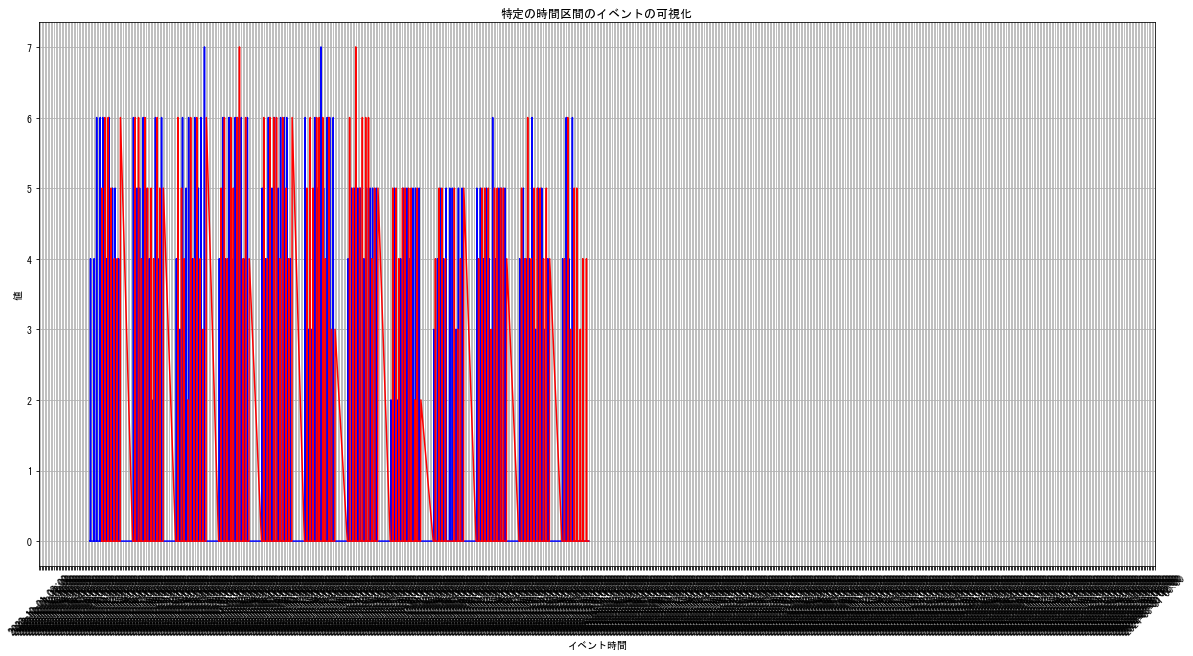

In [654]:
# 表示したい区間を指定
start_date2 = '2023-10-08 08:00:00'
end_date2 = '2023-12-29 17:00:00'

# 区間でフィルタリング
filtered_series = hourly_order[start_date2:end_date2]
filtered_series2 = hourly_reception[start_date2:end_date2].shift(46)

# フィルタリング結果を確認
print("フィルタリングされたシリーズ:\n", filtered_series)
print(hourly_order.sum(),hourly_reception.sum(),hourly_target.sum())

# プロット
plt.figure(figsize=(20, 10))
plt.plot(filtered_series.index, filtered_series.values, 'b')
plt.plot(filtered_series2.index, filtered_series2.values, 'r')
plt.xlabel('イベント時間')
plt.ylabel('値')
plt.title('特定の時間区間のイベントの可視化')
xticks = pd.date_range(start=start_date, end=end_date, freq='6H')
plt.xticks(xticks, xticks.strftime('%Y-%m-%d %H:%M'), rotation=45)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


#plt.figure(figsize=(20, 10))
#plt.plot(hourly_order,'b')
#plt.plot(hourly_reception,'r')
#plt.xlabel('日時')
#plt.show()

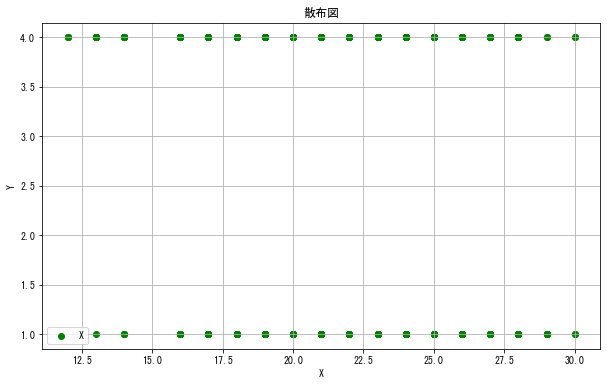

出庫かんばん数（t-0~t-51） 列の値が0の行:
0


,日時,生産台数_加重平均済


In [678]:
df = lagged_features3
#df = df[(df.index >= start_date) & (df.index <= end_date)]
end_hours_ago = 0
reception_timelag = timelag2

#------------------------------------------------------------------------------------------------------------------
#明日やること
#50時間だから前半50時間削除、
#冬休みも削除
# 最初の100行を削除
df= df.iloc[300:]
# 削除する日付範囲を指定
start = '2023-12-30'
end = '2024-03-31'#いまのデータが3/31ないから
# 日付範囲に基づいてフィルタリングして削除
df= df[~((df['日時'] >= start) & (df['日時'] <= end))]
#------------------------------------------------------------------------------------------------------------------

# 散布図の作成
plt.figure(figsize=(10, 6))
#plt.scatter(df[f'入庫かんばん数（t-{end_hours_ago}~t-{timelag}）'], df[f'発注かんばん数（t-{timelag}~t-{timelag*2}）'], color='b', label='X')
plt.scatter(df[f'入庫かんばん数（t-{end_hours_ago}~t-{timelag}）'], df['仕入先便到着フラグ'], color='g', label='X')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('散布図')
plt.legend()
plt.grid(True)
plt.show()

# 列名を指定して、その列の値が0の行を表示
column_name = f'出庫かんばん数（t-{Y}~t-{timelag}）'
rows_with_zero_in_column = df[df[column_name] == 0]

print(f"{column_name} 列の値が0の行:")
print(len(rows_with_zero_in_column))
rows_with_zero_in_column[['日時','生産台数_加重平均済']].head(50)

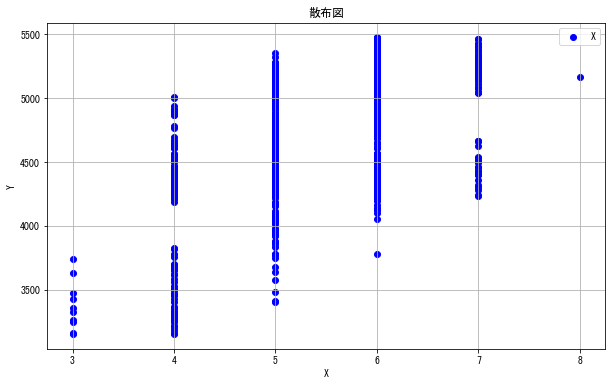

In [672]:
# 散布図の作成
plt.figure(figsize=(10, 6))
plt.scatter(df[f'出庫かんばん数（t-{end_hours_ago}~t-{timelag}）'], df[f'計画生産台数_加重平均（t-{end_hours_ago}~t-{timelag}）'], color='b', label='X')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('散布図')
plt.legend()
plt.grid(True)
plt.show()

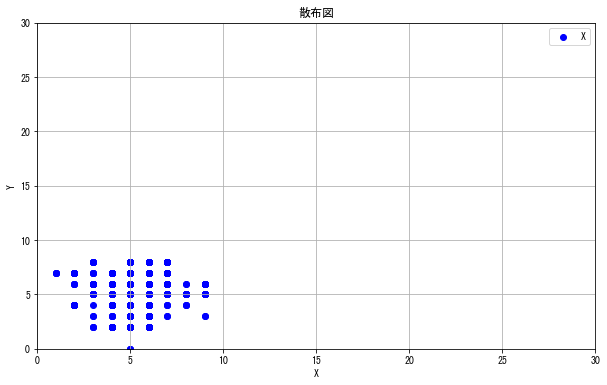

In [673]:
# 散布図の作成
plt.figure(figsize=(10, 6))
plt.scatter(df[f'発注かんばん数（t-{timelag}~t-{timelag*2}）'], df[f'納入かんばん数（t-{reception_timelag}~t-{timelag+reception_timelag}）'], color='b', label='X')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('散布図')
plt.legend()
plt.grid(True)
plt.show()

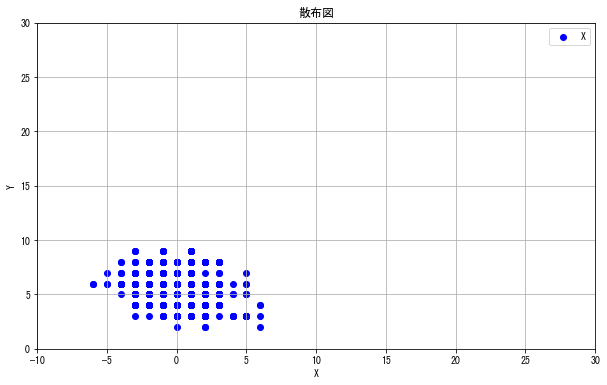

In [674]:
# 散布図の作成
plt.figure(figsize=(10, 6))
plt.scatter(df[f'納入かんばん数（t-{reception_timelag}~t-{timelag+reception_timelag}）']-df[f'発注かんばん数（t-{timelag}~t-{timelag*2}）'],
            df[f'入庫かんばん数（t-{end_hours_ago}~t-{timelag}）'], color='b', label='X')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-10, 30)
plt.ylim(0, 30)
plt.title('散布図')
plt.legend()
plt.grid(True)
plt.show()

In [618]:
# NaN値を処理する（例: 0で埋める）
lagged_features3 = lagged_features3.fillna(0)
#------------------------------------------------------------------------------------------------------------------
#削除、今は24年度のデータがないから
start = '2023-12-30'
end = '2024-03-31'
# 日付範囲に基づいてフィルタリングして削除
lagged_features3= lagged_features3[~((lagged_features3['日時'] >= start) & (lagged_features3['日時'] <= end))]
#------------------------------------------------------------------------------------------------------------------

data = lagged_features3

data['差分']=data[f'発注かんばん数（t-{timelag}~t-{timelag*2}）']-data[f'納入かんばん数（t-{reception_timelag}~t-{timelag+reception_timelag}）']

# 説明変数の定義
X = data[[f'発注かんばん数（t-{timelag}~t-{timelag*2}）',f'計画生産台数_加重平均（t-{end_hours_ago}~t-{timelag}）','差分']]
#X = data[['計画生産台数_加重平均済（t-52~t-0）']]
# 目的変数の定義
y = data[f'在庫増減数（t-0~t-{timelag}）']

# 1以上の数値をフィルタリング
greater_than_1 = y[y >= 1]

# -1以下の数値をフィルタリング
less_than_equal_minus1 = y[y <= -1]

# 1以上-1以下の数値をフィルタリング
between_1_and_minus1 = y[(y > -1) & (y < 1)]

print("1以上の数値の数:", len(greater_than_1))
print("-1以下の数値の数:", len(less_than_equal_minus1))
print("1以上でも-1以下でもない数値の数:", len(between_1_and_minus1))

# 目標個数を指定
target_count = 1720

# 現在の個数を取得
current_count = len(between_1_and_minus1)

print(y.index)
print(X.index)

# 減らす必要がある場合、ランダムに削除
if current_count > target_count:
    # ランダムに選択するインデックスを決定
    indices_to_keep = np.random.choice(between_1_and_minus1.index, size=target_count, replace=False)
    # 選択したインデックスに対応する値を保持
    between_1_and_minus1_filtered = y.loc[indices_to_keep]
else:
    # すでに目標個数以下の場合、そのまま使用
    between_1_and_minus1_filtered = between_1_and_minus1
    
print(len(between_1_and_minus1_filtered))

# 調整後の説明変数と目的変数の結合
y_filtered = pd.concat([greater_than_1, less_than_equal_minus1, between_1_and_minus1_filtered])
X_filtered = X.loc[y_filtered.index]
print(y_filtered.index)
print(X_filtered.index)

# データの整合性を再確認
X_filtered, y_filtered = X_filtered.align(y_filtered, join='inner', axis=0)

# データを学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)
print("X_train_filteredのサイズ",len(X_train),len(y_train),len(X_test),len(y_test))
X_train.head(30)
# データを学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print("X_trainのサイズ",len(X_train),len(y_train),len(X_test),len(y_test))

1以上の数値の数: 1200
-1以下の数値の数: 1365
1以上でも-1以下でもない数値の数: 563
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127],
           dtype='int64', length=3128)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127],
           dtype='int64', length=3128)
563
Int64Index([ 110,  111,  112,  113,  114,  115,  116,  117,  118,  119,
            ...
            3076, 3077, 3078, 3079, 3080, 3081, 3085, 3097, 3098, 3099],
           dtype='int64', length=3128)
Int64Index([ 110,  111,  112,  113,  114,  115,  116,  117,  118,  119,
            ...
            3076, 3077, 3078, 3079, 3080, 3081, 3085, 3097, 3098, 3099],
           dtype='int64', length=3128)
X_train_filteredのサイズ 2502 2502 626 626


In [644]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

# Lasso回帰モデルの作成
ridge = Ridge(alpha=0.1)

# モデルの訓練
ridge.fit(X_train, y_train)

# 予測
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# 評価
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

max_error_train = max_error(y_train, y_pred_train)
max_error_test = max_error(y_test, y_pred_test)

# マイナス方向の最大誤差を計算
min_error_train = np.min(y_train - y_pred_train)
min_error_test = np.min(y_test - y_pred_test)

print(f'Ridge回帰 - 訓練データのMSE: {mse_train}')
print(f'Ridge回帰 - テストデータのMSE: {mse_test}')
print(f'Ridge回帰 - 訓練データの最大誤差: {max_error_train}')
print(f'Ridge回帰 - テストデータの最大誤差: {max_error_test}')
print(f'Ridge回帰 - 訓練データのマイナス方向の最大誤差: {min_error_train}')
print(f'Ridge回帰 - テストデータのマイナス方向の最大誤差: {min_error_test}')

y_pred = ridge.predict(X)
y_pred_df = pd.DataFrame(y_pred, columns=['在庫増減_Predicted'])

X.head(50)

Ridge回帰 - 訓練データのMSE: 6.041501260140738
Ridge回帰 - テストデータのMSE: 6.101631745515903
Ridge回帰 - 訓練データの最大誤差: 10.105424974206185
Ridge回帰 - テストデータの最大誤差: 8.55914264730226
Ridge回帰 - 訓練データのマイナス方向の最大誤差: -10.105424974206185
Ridge回帰 - テストデータのマイナス方向の最大誤差: -7.35151913572559


,発注かんばん数（t-51~t-102）,計画生産台数_加重平均（t-0~t-51）,差分
0,0.0,55.000000,0.0
1,0.0,175.000000,0.0
2,0.0,294.000000,0.0
3,0.0,413.000000,0.0
4,0.0,478.500000,0.0
5,0.0,526.500000,0.0
6,0.0,623.500000,0.0
7,0.0,726.833333,0.0
8,0.0,843.500000,0.0
9,0.0,884.166667,0.0


In [645]:
# 訓練データとテストデータの形状を確認
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X shape:", X.shape)

# ランダムフォレストモデルの訓練
rf_model = RandomForestRegressor(n_estimators=10, max_depth=20,random_state=42)
rf_model.fit(X_train, y_train)
# テストデータで予測し、MSEを計算
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

X_train.head()

X_train shape: (1251, 3)
X_test shape: (313, 3)
X shape: (1564, 3)
MSE: 3.9737721317382015


/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >

,発注かんばん数（t-51~t-102）,計画生産台数_加重平均（t-0~t-51）,差分
1380,19.0,3168.000000,0.0
570,21.0,3657.833333,0.0
867,29.0,3679.666667,11.0
787,22.0,3079.000000,0.0
1425,22.0,3063.833333,3.0


/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .r

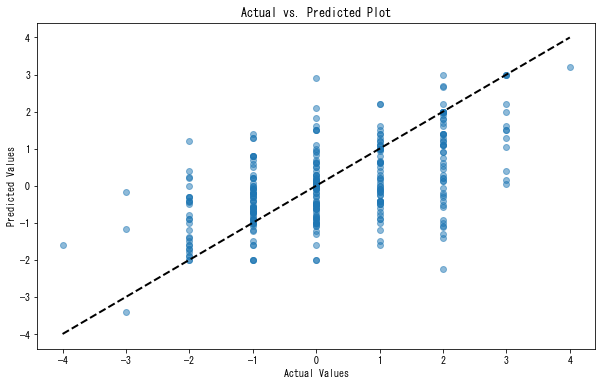

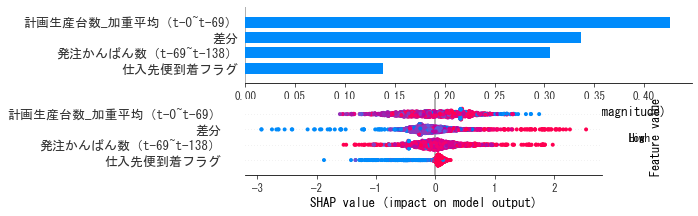

In [669]:
# フォント設定の変更（日本語対応のため）
mpl.rcParams['font.family'] = 'MS Gothic'

# データフレームXから100行目から300行目までのデータを選択
X_subset = X.iloc[0:5000]
# モデルを使ってX_subsetから予測値を計算
y_pred_subset = rf_model.predict(X_subset)
# y_test_subset を用意する必要がある
# この例では単に y_test の対応する部分を選択することを仮定
y_test_subset = y_test.loc[X_subset.index]

# 実測値と予測値をプロット
plt.figure(figsize=(10, 6))
# 散布図で実測値と予測値をプロット
# alpha=0.5で点の透明度を設定して、データポイントが重なる場合に可視性を高める
plt.scatter(y_test_subset, y_pred_subset, alpha=0.5)
# 対角線を描画（完璧な予測を示す線）
# y_test_subsetの最小値から最大値までの線を引く
plt.plot([y_test_subset.min(), y_test_subset.max()], [y_test_subset.min(), y_test_subset.max()], 'k--', lw=2)
# X軸のラベルを設定
plt.xlabel('Actual Values')
# Y軸のラベルを設定
plt.ylabel('Predicted Values')
# タイトルを設定
plt.title('Actual vs. Predicted Plot')

# 図を表示
plt.show()

# SHAP計算
explainer = shap.TreeExplainer(rf_model, feature_dependence='tree_path_dependent', model_output='margin')
shap_values_subset = explainer.shap_values(X_subset)

# グリッドレイアウトの設定
fig = plt.figure(figsize=(20, 20))  # サイズを実用的な大きさに調整
gs = GridSpec(2, 1, figure=fig)

# SHAPサマリープロット
ax1 = fig.add_subplot(gs[0, 0])
shap.summary_plot(shap_values_subset, X_subset, feature_names=X.columns, plot_type="bar", show=False)

# 平均絶対SHAP値のバープロット
ax2 = fig.add_subplot(gs[1, 0])
shap.summary_plot(shap_values_subset, X_subset, feature_names=X.columns, show=False)

                   日時  発注かんばん数（t-50~t-52）  入庫かんばん数（t）  出庫かんばん数（t）  \
0 2023-10-02 08:00:00                 0.0           0           0   
1 2023-10-02 09:00:00                 0.0           0           0   
2 2023-10-02 10:00:00                 0.0           0           0   
3 2023-10-02 11:00:00                 0.0           0           0   
4 2023-10-02 12:00:00                 0.0           0           0   

   納入かんばん数（t-4~t-7）  納入便（t-4~t-7）  在庫増減数(t)  未納or挽回数  紛失or滞留数  発注かんばん数(t)  \
0               0.0             0         0      0.0      0.0           0   
1               0.0             0         0      0.0      0.0           0   
2               0.0             0         0      0.0      0.0           0   
3               0.0             0         0      0.0      0.0           3   
4               0.0             0         0      0.0      0.0           0   

   ...  計画達成率_加重平均済 生産台数_加重平均（t-0~t-52） 計画生産台数_加重平均（t-0~t-51）  \
0  ...     0.916667                55.0                  

/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


shap_df 1564
shap_df_sortedt 1564
dfdf 4
dfdf_subset 4


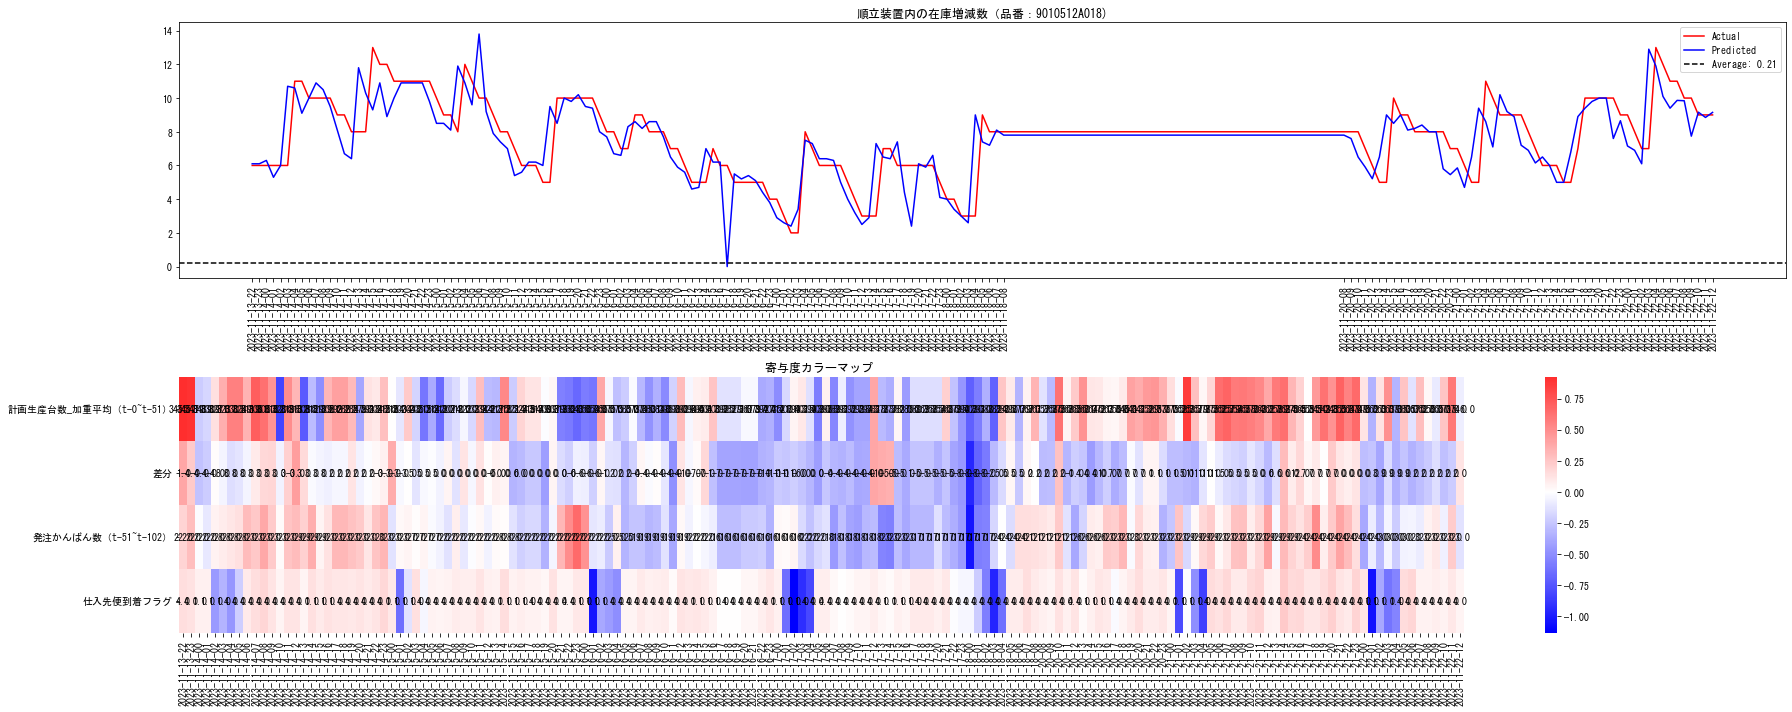

In [725]:
# 図の作成
plt.figure(figsize=(25, 10))

start = 0
end = 2999

#df= data[data['品番'] == '019128GA010']
df=data.iloc[start:end]
print(df.head())

X_subset = X.iloc[start:end]
# モデルを使ってX_subsetから予測値を計算
y_pred_subset = rf_model.predict(X_subset)

df['日時'] = pd.to_datetime(df['日時'])
df.set_index('日時', inplace=True)

#df2 = df['在庫増減数（t-52~t-0）']
df2 = df['在庫数（箱）']
print(df2.head())

# プロットするデータの範囲を指定（例：最初の30個のデータを表示）
start_idx =  740
end_idx =900

# プロットするデータの範囲をスライス
df2_subset = df2[start_idx:end_idx]
y_pred_subset = y_pred_subset[start_idx:end_idx]
#-----------------------------------------------------------------------
yyyy = df[f'在庫数（箱）（t-{timelag}）']
y_base_subset = yyyy[start_idx:end_idx]
#-----------------------------------------------------------------------

print("df2",len(df2))
print("df2_subset",len(df2_subset))
print("y_pred_subset",len(y_pred_subset))

# 折れ線グラフのサブプロット
plt.subplot(2, 1, 1) # (rows, columns, subplot number)
plt.plot(df2_subset.index, df2_subset,  linestyle='-', color='red',label='Actual')
plt.plot(df2_subset.index, y_pred_subset+y_base_subset, linestyle='-', color='blue', label='Predicted')
#plt.title('順立装置内の在庫推移（品番：82824ECE010、品名：CONNECTOR, WIRING HARNESS）')
# データの平均値を計算
mean_value = y.mean()
# 平均線の追加
plt.axhline(y=mean_value, color='black', linestyle='--', label=f'Average: {mean_value:.2f}')
plt.legend()  # 凡例の表示
plt.xticks(ticks=df2_subset.index, labels=df2_subset.index.strftime('%Y-%m-%d-%H'), rotation=90)  # 日付フォーマットは必要に応じて調整
plt.title('順立装置内の在庫増減数（品番：9010512A018)')
plt.tight_layout()

#--------------------------------------------------------------------------

# SHAP値からデータフレームを作成
shap_df = pd.DataFrame(shap_values_subset, columns=X.columns)

# データフレームの平均SHAP値に基づいて特徴量を並び替え
shap_df_mean = shap_df.abs().mean().sort_values(ascending=False)
sorted_columns = shap_df_mean.index

shap_df_sorted = shap_df[sorted_columns]

dfdf = shap_df_sorted.iloc[start:end].T

# プロットするデータの範囲をスライス
dfdf_subset = dfdf.iloc[:, start_idx:end_idx]

print("shap_df",len(shap_df))
print("shap_df_sortedt",len(shap_df_sorted))
print("dfdf",len(dfdf))
print("dfdf_subset",len(dfdf_subset))
    
# カラーマップ（ヒートマップ）のサブプロット
plt.subplot(2, 1, 2)
sns.heatmap(dfdf_subset, cmap='bwr', cbar=True, center=0)  # Transpose the DataFrame
plt.title('寄与度カラーマップ ')
plt.xticks(np.arange(0.5, len(df2_subset.index)), df2_subset.index.strftime('%Y-%m-%d-%H'), rotation=90)
# 各セルに値を追記
X = X.reindex(columns=shap_df_sorted.columns)
XX = X[start:end].T
XX_subset = XX.iloc[:, start_idx:end_idx]

for i in range(XX_subset.shape[0]):
    for j in range(XX_subset.shape[1]):
        formatted_value = "{:.1f}".format(XX_subset.iloc[i, j])
        text = plt.text(j+0.5, i+0.5, formatted_value,
                       ha="center", va="center", color="black")
plt.tight_layout()

filename = 'モ'+ '.png'
plt.savefig(filename)

In [201]:
print(len(df[f'在庫数（箱）（t-{timelag}）']),len(dfdf.iloc[:, start_idx:end_idx]))

1564 3


In [495]:
arrival_times_df.head(10)

5,仕入先名,発送場所名,受入,1便_早着,1便_定刻,1便_遅着,2便_早着,2便_定刻,2便_遅着,3便_早着,...,3便_遅着,4便_早着,4便_定刻,4便_遅着,5便_早着,5便_定刻,5便_遅着,6便_早着,6便_定刻,6便_遅着
0,アイシン精機（株）,半田工場,1Y,08:30:00,10:30:00,12:30:00,12:40:00,14:40:00,16:40:00,19:00:00,...,23:00:00,00:10:00,02:10:00,04:10:00,NaT,NaT,NaT,NaT,NaT,NaT
2,（株）青山製作所,NaN,1Y,05:00:00,07:00:00,09:00:00,09:20:00,11:20:00,13:20:00,12:55:00,...,16:55:00,17:40:00,19:40:00,21:40:00,21:00:00,23:00:00,01:00:00,01:00:00,03:00:00,05:00:00
4,（株）浅賀井製作所,安城工場,1Y,07:50:00,09:50:00,11:50:00,13:10:00,15:10:00,17:10:00,19:30:00,...,23:30:00,00:30:00,02:30:00,04:30:00,NaT,NaT,NaT,NaT,NaT,NaT
6,（株）旭工業所,本社工場,1Y,14:40:00,16:40:00,18:40:00,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,愛産樹脂工業（株）,本社工場,1Y,13:00:00,15:00:00,17:00:00,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
10,石黒ゴム工業（株）,NaN,1Y,06:45:00,08:45:00,10:45:00,12:00:00,14:00:00,16:00:00,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
12,伊藤金属工業（株）,NaN,1Y,11:00:00,13:00:00,15:00:00,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
14,（株）オーハシテクニカ,NaN,1Y,13:20:00,15:20:00,17:20:00,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
16,大橋鉄工（株）,NaN,1Y,14:20:00,16:20:00,18:20:00,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
18,岡谷鋼機（株）,刈谷支店,1Y,19:50:00,21:50:00,23:50:00,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


必要なかんばんの枚数: 12


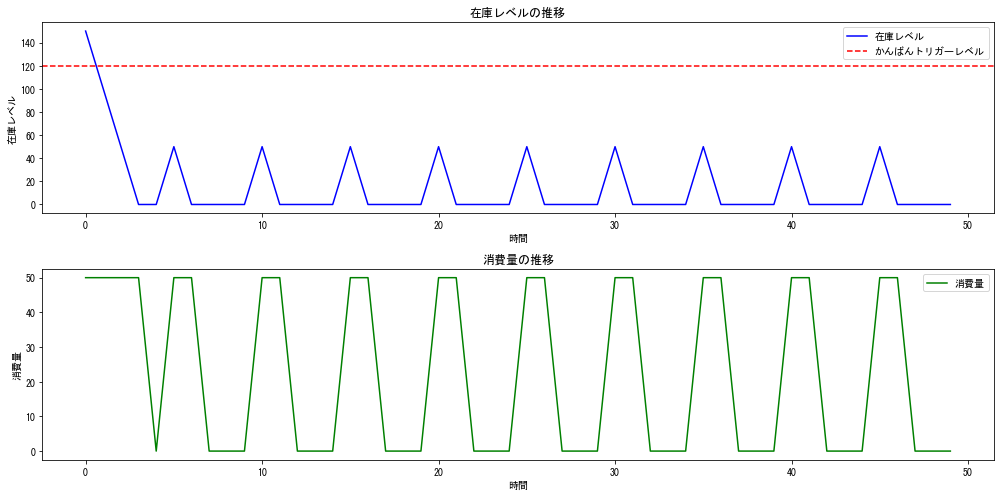

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_kanban_system(consumption_rate, lead_time, safety_stock_rate, batch_size, initial_stock, simulation_time, order_interval, order_quantity):
    """
    かんばんシステムのシミュレーションを実行し、在庫レベルと消費量をプロットする関数。

    Parameters:
    consumption_rate (float): 消費率（単位時間あたりの消費量）
    lead_time (float): リードタイム（時間）
    safety_stock_rate (float): 安全在庫率
    batch_size (float): 1かんばんあたりのバッチサイズ
    initial_stock (float): 初期在庫
    simulation_time (int): シミュレーションの総時間
    order_interval (int): 発注間隔（時間）
    order_quantity (int): 発注量

    Returns:
    None
    """
    # かんばん数の計算
    kanban_number = (consumption_rate * lead_time * (1 + safety_stock_rate)) / batch_size
    kanban_number = int(kanban_number)
    print(f"必要なかんばんの枚数: {kanban_number}")

    # シミュレーションの実行
    time_points = np.arange(simulation_time)
    stock_levels = []
    consumptions = []

    current_stock = initial_stock
    for t in time_points:
        if t % order_interval == 0:  # 定期的に発注
            current_stock += order_quantity
        
        consumption = min(consumption_rate, current_stock)  # 在庫が足りない場合は消費量が在庫量に制限される
        current_stock -= consumption
        
        stock_levels.append(current_stock)
        consumptions.append(consumption)

    # グラフのプロット
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.plot(time_points, stock_levels, label='在庫レベル', color='blue')
    plt.axhline(y=kanban_number * batch_size, color='red', linestyle='--', label='かんばんトリガーレベル')
    plt.xlabel('時間')
    plt.ylabel('在庫レベル')
    plt.title('在庫レベルの推移')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time_points, consumptions, label='消費量', color='green')
    plt.xlabel('時間')
    plt.ylabel('消費量')
    plt.title('消費量の推移')
    plt.legend()

    plt.tight_layout()
    plt.show()

# パラメータの設定
consumption_rate = 50  # 単位時間あたりの消費量
lead_time = 2          # リードタイム（時間）
safety_stock_rate = 0.2 # 安全在庫率
batch_size = 10        # 1かんばんあたりのバッチサイズ
initial_stock = 100    # 初期在庫
simulation_time = 50   # シミュレーションの総時間
order_interval = 5     # 発注間隔（時間）
order_quantity = 100   # 発注量

# シミュレーションの実行
simulate_kanban_system(consumption_rate, lead_time, safety_stock_rate, batch_size, initial_stock, simulation_time, order_interval, order_quantity)
